<a href="https://www.kaggle.com/code/niltonpegass/yellow-taxi-regression-fare-predict?scriptVersionId=264699614" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# NEW YORK CITY YELLOW TAXI - **TRIP FARE PREDICTION**

**[ 🇧🇷 PT | 🇺🇸 EN ]**

Prever o valor de corridas de táxi em uma metrópole como Nova Iorque é um desafio de alto impacto, tanto do ponto de vista operacional quanto econômico. O setor de transporte urbano movimenta milhões de viagens diariamente, e compreender os fatores que influenciam o preço final da corrida pode trazer benefícios para diferentes partes interessadas: motoristas, empresas de mobilidade e passageiros.  

Neste projeto, o objetivo é desenvolver **modelos de regressão** capazes de estimar o valor da corrida (fare amount) a partir de variáveis relacionadas à viagem. O dataset utilizado contém informações históricas de viagens reais, incluindo:  

- Distância da viagem  
- Local e horário de embarque  
- Número de passageiros  
- Duração estimada da corrida  

Ao analisar esses dados, busca-se identificar padrões e construir modelos preditivos que ofereçam **transparência, previsibilidade e suporte à tomada de decisão** no setor de transporte.

---

**[ 🇺🇸 EN ]**

Predicting taxi fares in a metropolis like New York City is a high-impact challenge, both operationally and economically. The urban transportation sector handles millions of rides every day, and understanding the factors that drive the final fare can provide value for multiple stakeholders: drivers, mobility companies, and passengers alike.  

This project aims to develop **regression models** capable of estimating the fare amount using trip-related variables. The dataset is based on real historical ride data and includes:  

- Trip distance  
- Pickup location and time  
- Number of passengers  
- Estimated trip duration  

By analyzing these features, the goal is to uncover patterns and build predictive models that deliver **transparency, reliability, and decision support** for the transportation industry.

---

#### OBJETIVO / OBJECTIVE
**[ 🇧🇷 PT ]** Construir modelos preditivos de Machine Learning capazes de estimar o valor da corrida com base em padrões históricos.  
Isso permite maior transparência e previsibilidade para usuários e profissionais do setor.  

**[ 🇺🇸 EN ]** Build predictive Machine Learning models capable of estimating the fare amount based on historical patterns.  
This enables greater transparency and predictability for users and professionals in the field.  

#### MODELOS UTILIZADOS / MODELS USED
- Regressão Linear / Linear Regression  
- Árvore de Decisão / Decision Tree  
- Floresta Aleatória / Random Forest  
- XGBoost  

#### MÉTRICAS AVALIADAS / EVALUATED METRICS
- **R²**: Coeficiente de Determinação / Coefficient of Determination  
- **RMSE**: Erro Quadrático Médio Root / Mean Squared Error  
- **MAE**: Erro Absoluto Médio / Mean Absolute Error  

#### TECNOLOGIAS E FERRAMENTAS / TECHNOLOGIES AND TOOLS
- **Linguagem / Language**: Python 3.x  
- **Manipulação de Dados / Data Handling**: Pandas, NumPy  
- **Visualização / Visualization**: Matplotlib, Seaborn  
- **Modelagem / Modeling**: Scikit-learn, LightGBM, XGBoost  
- **Validação / Validation**: train_test_split, GridSearchCV, cross-validation  


|  | **[ 🇧🇷 PT ] NAVEGUE PELAS SEÇÕES<br>[ 🇺🇸 EN ] NAVIGATE THROUGH SECTIONS** |  | 
|---------------------------------|-----------------------------|-------------------------------|
|              <a href="#ANÁLISE-EXPLORATÓRIA-DE-DADOS-(EDA)-/-EXPLORATORY-DATA-ANALYSIS-(EDA)">> ANÁLISE EXPLORATÓRIA (EDA)<br>> EXPLORATORY ANALYSIS (EDA)</a>              |          <a href="#ENGENHARIA-DE-ATRIBUTOS-/-FEATURE-ENGINEERING">> ENGENHARIA DE ATRIBUTOS<br>> FEATURE ENGINEERING</a>              |            <a href="#AVALIAÇÃO-DO-MODELO-/-MODEL-EVALUATION">> AVALIAÇÃO DO MODELO<br>> MODEL EVALUATION</a>              |
|              <a href="#VERIFICAÇÃO-DE-PREMISSAS-/-ASSUMPTION-CHECKING">> VERIFICAÇÃO DE PREMISSAS<br>> ASSUMPTION CHECKING</a>              |          <a href="#PRÉ-PROCESSAMENTO-/-PRE-PROCESSING">> PRÉ-PROCESSAMENTO<br>> PREPROCESSING</a>              |            <a href="#CONCLUSÕES-/-CONCLUSIONS">> CONCLUSÕES<br>> CONCLUSIONS</a>              |
|              <a href="#AVALIAÇÃO-RÁPIDA-DO-MODELO-/-FAST-MODEL-EVALUATION">> AVALIAÇÃO RÁPIDA DO MODELO<br>> FAST MODEL EVALUATION</a>              |          <a href="#MODELAGEM-/-MODELING">> MODELAGEM<br>> MODELING</a>              |            <a href="#APÊNDICE---TESTE-A/B-(ANÁLISE-EXTRA)-/-APPENDIX---A/B-TEST-(EXTRA-ANALYSIS)">> APÊNDICE - TESTE A/B<br>> APPENDIX   A/B TEST</a>              |

## **RESUMO** / SUMMARY

## **RESUMO / SUMMARY**

**[ 🇧🇷 PT ]**

Este trabalho teve como objetivo o desenvolvimento de modelos preditivos capazes de estimar o valor de corridas de táxi de forma transparente e confiável. Foram consideradas variáveis como distância percorrida, tempo de deslocamento, número de passageiros e características contextuais relacionadas a data e hora.  

Durante as etapas iniciais, foi realizada uma análise exploratória detalhada para compreender o comportamento dos dados, incluindo a **detecção e tratamento de outliers**, que impactavam fortemente a distribuição de variáveis contínuas como distância e valor da corrida. Observou-se que o dataset apresenta **predominância de viagens curtas em tempo e distância**, refletindo o perfil urbano típico das corridas de táxi em Nova Iorque.  

Além disso, foram criadas **novas features derivadas** (ex.: variáveis temporais e indicadores de fim de semana) para enriquecer o conjunto de dados e melhorar a capacidade explicativa dos modelos.  

Diferentes algoritmos de regressão foram avaliados — incluindo Regressão Linear, Árvore de Decisão, Random Forest e XGBoost. A comparação entre eles mostrou que o **XGBoost apresentou o melhor equilíbrio entre desempenho e generalização**, alcançando **R² ≈ 0.986, RMSE ≈ 1.17 e MAE ≈ 0.44**, com diferença residual entre treino e teste em torno de 0.04.  

Esses resultados evidenciam a construção de um modelo robusto, estável e aplicável a cenários práticos, oferecendo previsões precisas tanto para usuários quanto para profissionais do setor de mobilidade.  

---

**[ 🇺🇸 EN ]**

This project aimed to develop predictive models capable of estimating taxi fares with transparency and reliability. Variables such as trip distance, trip duration, passenger count, and contextual information (date and time) were considered.  

In the initial stages, a detailed exploratory analysis was conducted to better understand data behavior, including the **detection and treatment of outliers**, which strongly affected the distribution of continuous variables such as distance and fare amount. It was also observed that the dataset shows a **predominance of short trips in both time and distance**, highlighting the urban profile of New York City taxi rides.  

Additionally, **new engineered features** (e.g., temporal variables and weekend indicators) were created to enrich the dataset and improve the explanatory power of the models.  

Several regression algorithms were tested — including Linear Regression, Decision Tree, Random Forest, and XGBoost. The benchmarking process showed that **XGBoost achieved the best balance between accuracy and generalization**, with **R² ≈ 0.986, RMSE ≈ 1.17, and MAE ≈ 0.44**, while maintaining a residual difference between training and testing data of about 0.04.  

These results demonstrate the development of a robust, consistent, and practically applicable model, capable of delivering accurate predictions for both end-users and transportation professionals.  


#### **COMPREENSÃO INICIAL DE DADOS, IMPORTAÇÃO DE PACOTES E LEITURA DE ARQUIVOS** / INITIAL DATA UNDERSTANDING, PACKAGE IMPORTING AND FILE READING

**[ 🇧🇷 PT | 🇺🇸 EN ]**

| **NOME DA COLUNA / COLUMN NAME** | **DESCRIÇÃO / DESCRIPTION**                                                                                                                                                                                                                                                                                                                                                                                                                      |
| :------------------------------: | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
|              **ID**              | Número de identificação da corrida<br>Trip identification number                                                                                                                                                                                                                                                                                                                                                                                |
|           **VendorID**           | Um código que indica o provedor TPEP responsável pelo registro.<br>A code indicating the TPEP provider that provided the record.<br><br>#1 = Creative Mobile Technologies, LLC;<br>#2 = VeriFone Inc.                                                                                                                                                                                                                                             |
|    **tpep\_pickup\_datetime**    | Data e hora em que o taxímetro foi acionado.<br>The date and time when the meter was engaged.                                                                                                                                                                                                                                                                                                                                                   |
|    **tpep\_dropoff\_datetime**   | Data e hora em que o taxímetro foi desligado.<br>The date and time when the meter was disengaged.                                                                                                                                                                                                                                                                                                                                               |
|       **Passenger\_count**       | Número de passageiros no veículo.<br>The number of passengers in the vehicle.                                                                                                                                                                                                                                                                                                                                                                   |
|        **Trip\_distance**        | Distância percorrida na corrida (em milhas), conforme reportado pelo taxímetro.<br>The elapsed trip distance in miles reported by the taximeter.                                                                                                                                                                                                                                                                                                |
|         **PULocationID**         | Zona TLC de táxi onde o taxímetro foi acionado.<br>TLC Taxi Zone in which the taximeter was engaged.                                                                                                                                                                                                                                                                                                                                            |
|         **DOLocationID**         | Zona TLC de táxi onde o taxímetro foi desligado.<br>TLC Taxi Zone in which the taximeter was disengaged.                                                                                                                                                                                                                                                                                                                                        |
|          **RateCodeID**          | Código da tarifa em vigor ao final da corrida.<br>The final rate code in effect at the end of the trip.<br><br>#1 = Tarifa padrão<br>#1 = Standard rate<br>#2 = JFK<br>#3 = Newark<br>#4 = Nassau ou Westchester<br>#5 = Tarifa negociada<br>#5 = Negotiated fare<br>#6 = Corrida compartilhada<br>#6 = Group ride                                                                                                                      |
|     **Store\_and\_fwd\_flag**    | Indica se o registro da corrida foi armazenado na memória do veículo antes de ser enviado ao provedor ("store and forward"), devido à ausência de conexão com o servidor.<br>This flag indicates whether the trip record was held in vehicle memory before being sent to the vendor, aka “store and forward.”<br><br>Y = corrida armazenada e encaminhada<br>Y = store and forward trip<br>N = corrida não armazenada<br>N = not a store and forward trip |
|         **Payment\_type**        | Código numérico que indica como o passageiro pagou a corrida.<br>A numeric code signifying how the passenger paid for the trip.<br><br>#1 = Cartão de crédito<br>#1 = Credit card<br>#2 = Dinheiro<br>#2 = Cash<br>#3 = Sem cobrança<br>#3 = No charge<br>#4 = Contestação<br>#4 = Dispute<br>#5 = Desconhecido<br>#5 = Unknown<br>#6 = Corrida cancelada<br>#6 = Voided trip                                                                                                     |
|         **Fare\_amount**         | Valor da tarifa baseada em tempo e distância calculada pelo taxímetro.<br>The time-and-distance fare calculated by the meter.                                                                                                                                                                                                                                                                                                                   |
|             **Extra**            | Extras e sobretaxas diversas. Atualmente inclui apenas cobranças de `$0,50` e `$1` em horários de pico e período noturno.<br>Miscellaneous extras and surcharges. Currently, this only includes the `$0.50` and `$1` rush hour and overnight charges.                                                                                                                                                                                                   |
|           **MTA\_tax**           | Taxa fixa de `$0,50` do MTA, acionada automaticamente conforme a tarifa em uso.<br>`$0.50` MTA tax that is automatically triggered based on the metered rate in use.                                                                                                                                                                                                                                                                                |
|    **Improvement\_surcharge**    | Sobretaxa de `$0,30` aplicada ao início da corrida (flag drop). Essa cobrança entrou em vigor em 2015.<br>`$0.30` improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.                                                                                                                                                                                                                      |
|          **Tip\_amount**         | Valor da gorjeta – este campo é preenchido automaticamente para gorjetas em cartão de crédito. Gorjetas em dinheiro não são incluídas.<br>Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.                                                                                                                                                                                                  |
|         **Tolls\_amount**        | Valor total de todos os pedágios pagos na corrida.<br>Total amount of all tolls paid in trip.                                                                                                                                                                                                                                                                                                                                                   |
|         **Total\_amount**        | Valor total cobrado do passageiro. Não inclui gorjetas em dinheiro.<br>The total amount charged to passengers. Does not include cash tips.                                                                                                                                                                                                                                                                                                      |

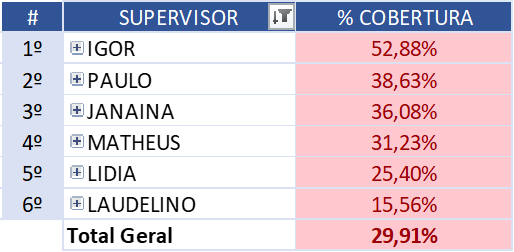
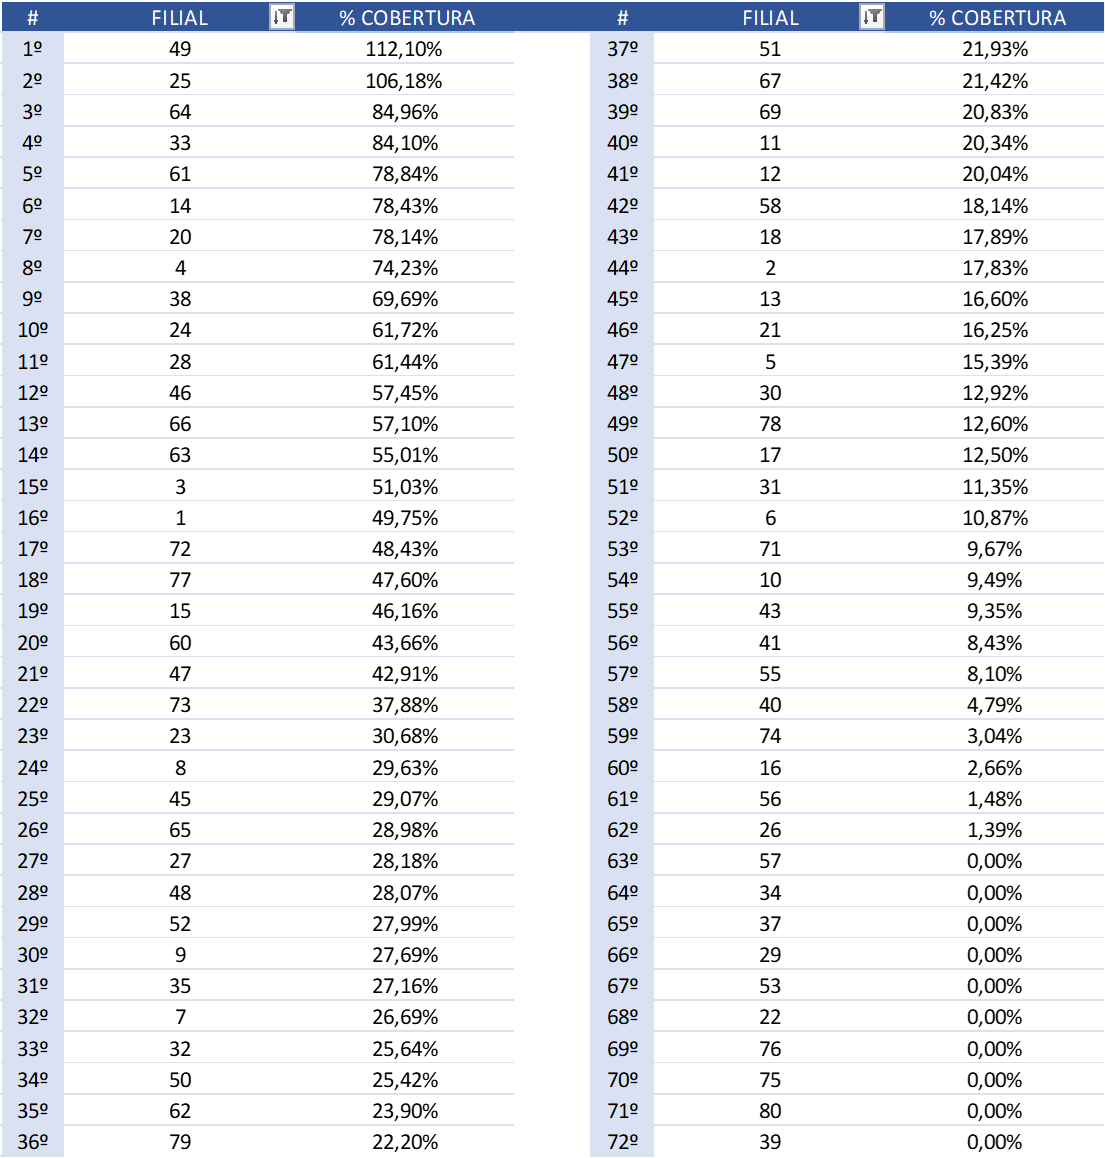

In [1]:
# ## IMPORTAÇÃO DE PACOTES
# ## PACKAGE IMPORTATION

# Utilidades do sistema
# System Utilities
import sys
import warnings
import contextlib
import datetime as dt

# Manipulação de dados
# Data manipulation
import pandas as pd
import numpy as np

# Visualização de Dados
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance
from pprint import pprint

# Estatística
# Statistics
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Pré-processamento e Modelos de Machine Learning
# Preprocessing and Machine Learning Models
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    HistGradientBoostingRegressor
)

# Boosting
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Validação e Treino
# Validation and Training
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    StratifiedKFold,
    KFold,
    TimeSeriesSplit,
    learning_curve
)

# Interpretação de Modelos e Otimização de Hiperparâmetros
# Model Interpretation and Hyperparameter Optimization
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Métricas
# Metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

# ## CONFIGURAÇÕES INICIAIS
# ## INITIAL SETTINGS

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# ## SILENCIAR WARNINGS
# ## SILENCE WARNINGS
@contextlib.contextmanager
def silence_stdout():
    with open('/dev/null', 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# ## CARREGAMENTO DE DADOS
# ## DATA LOADING

CSV_PATH = '/kaggle/input/new-york-city-taxi-trips-2017/2017_Yellow_Taxi_Trip_Data.csv'

sample_head = pd.read_csv(CSV_PATH, nrows=5)
print("Colunas detectadas:\n", sample_head.columns.tolist())

nrows = None #ex: 100000 para teste rápido, ou None para dataset completo
df = pd.read_csv(CSV_PATH, nrows=nrows)

Colunas detectadas:
 ['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']


## **VISÃO INICIAL DOS DADOS** / INITIAL DATA OVERVIEW

In [2]:
def display_dataset_overview(df: pd.DataFrame) -> None:
    """
    Exibe informações gerais sobre o dataset,
    incluindo dimensões, amostra de dados e estatísticas descritivas.

    Display general information about the dataset,
    including shape, variable descriptions, sample data, and summary statistics.
    """

    print(
        f">> Dataset shape: {df.shape[0]} rows and {df.shape[1]} columns "
        f"({df.shape[0] * df.shape[1]} data points)\n"
    )

    print(">> First 5 rows:")
    display(df.head(5))

    print(">> General dataset information:")
    display(df.info())

    print(">> Descriptive statistics:")
    display(df[['trip_distance', 'fare_amount', 'extra', 'tip_amount']].describe())

display_dataset_overview(df)

>> Dataset shape: 22699 rows and 18 columns (408582 data points)

>> First 5 rows:


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


>> General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount            

None

>> Descriptive statistics:


,trip_distance,fare_amount,extra,tip_amount
count,22699.000000,22699.000000,22699.000000,22699.000000
mean,2.913313,13.026629,0.333275,1.835781
std,3.653171,13.243791,0.463097,2.800626
min,0.000000,-120.000000,-1.000000,0.000000
25%,0.990000,6.500000,0.000000,0.000000
50%,1.610000,9.500000,0.000000,1.350000
75%,3.060000,14.500000,0.500000,2.450000
max,33.960000,999.990000,4.500000,200.000000


#### **CRIAÇÃO DE FEATURES BASE** / BASE FEATURE CREATION

In [3]:
#----------------------------------------
# PT: Conversão de datas e criação de variáveis de tempo (duração da corrida, hora, mês, dia da semana, fim de semana)
# EN: Conversion of datetime fields and creation of time-related features (trip duration, hour, month, day of week, weekend)
#----------------------------------------
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df['trip_duration'] = ((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60).round(2)
df['trip_distance'] = pd.to_numeric(df['trip_distance'], errors='coerce')

df['day_name'] = df['tpep_pickup_datetime'].dt.day_name().str[:3].str.lower()
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['is_weekend'] = df['day_name'].isin(['sat','sun'])

#----------------------------------------
# PT: Ajuste de colunas categóricas para string (RatecodeID, VendorID)
# EN: Conversion of categorical columns to string type (RatecodeID, VendorID)
#----------------------------------------
cols_to_str = ['RatecodeID', 'VendorID']
for col in cols_to_str:
    df[col] = df[col].astype('str')

## **ANÁLISE EXPLORATÓRIA DE DADOS (EDA)** / EXPLORATORY DATA ANALYSIS (EDA)

**<a href="#NEW-YORK-CITY-YELLOW-TAXI---TRIP-FARE-PREDICTION">VOLTAR PARA O INÍCIO / BACK TO HOME</a>**

#### **DISTRIBUIÇÕES BÁSICAS DAS VARIÁVEIS** / BASIC VARIABLE DISTRIBUTIONS

**[ 🇧🇷 PT | 🇺🇸 EN ]**

Nesta etapa, analisamos as distribuições de distância, tarifa e duração das corridas. Essa observação permite identificar se os dados apresentam simetria ou assimetria, a presença de outliers e possíveis concentrações em intervalos específicos, aspectos fundamentais para orientar o pré-processamento e a modelagem.

---
**[ 🇺🇸 EN ]**

At this stage, we analyze the distributions of trip distance, fare, and duration. This examination helps to identify whether the data exhibit symmetry or skewness, the presence of outliers, and potential concentrations within specific ranges, which are key aspects to guide preprocessing and modeling.

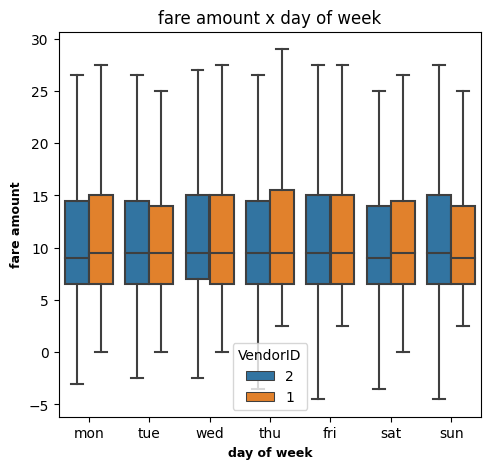

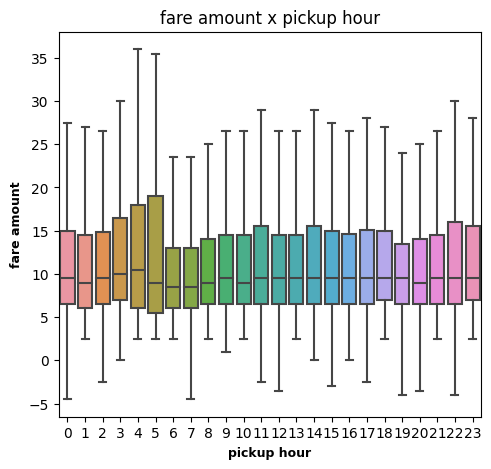

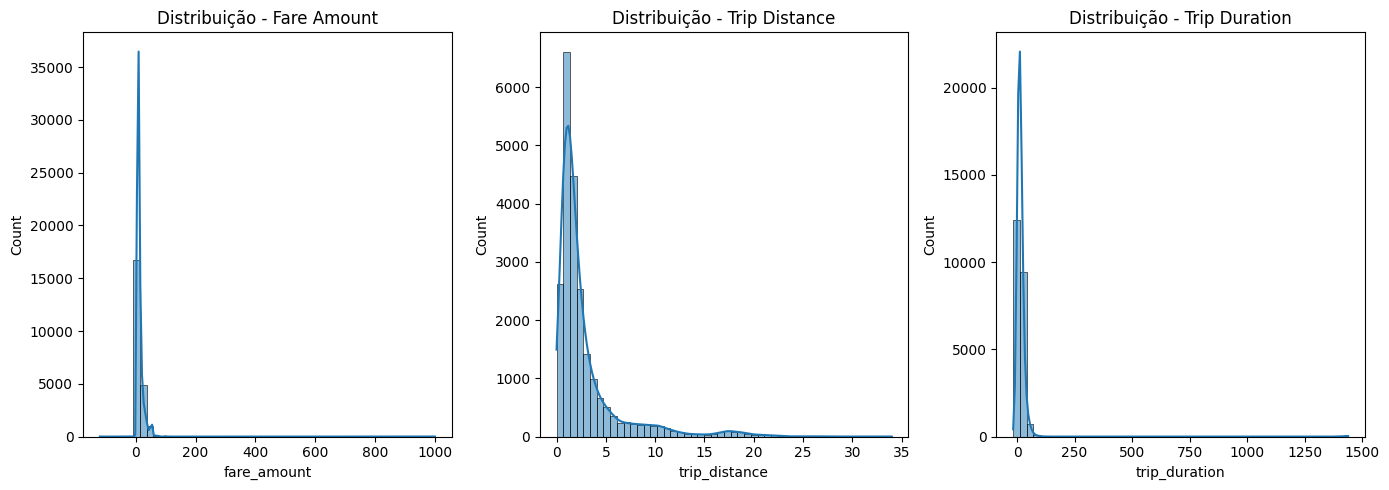

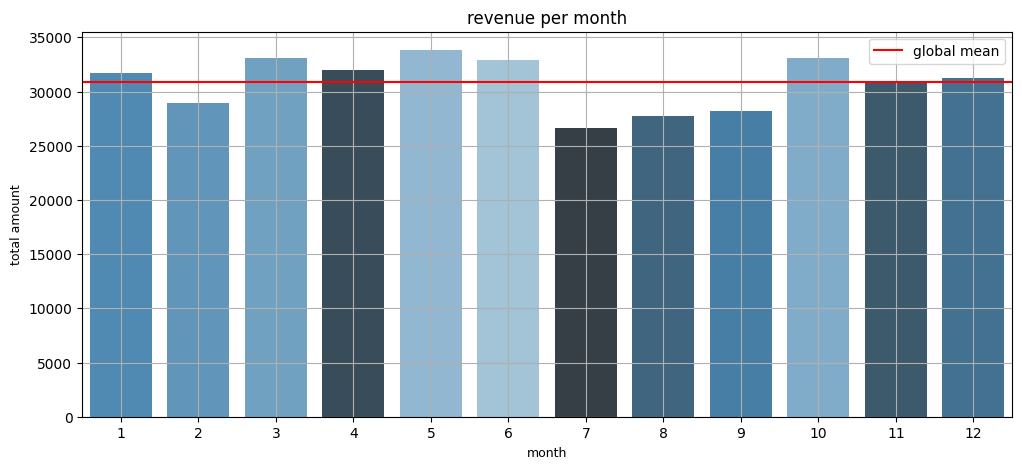

In [4]:
#----------------------------------------
# PT: Relações entre tarifa e variáveis temporais (dia da semana, hora de embarque) + distribuições de variáveis principais
# EN: Exploratory analysis with boxplots and histograms:
#     relationships between fare and time variables (day of week, pickup hour) + distributions of main features
#----------------------------------------

day_order = ['mon','tue','wed','thu','fri','sat','sun']

plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
sns.boxplot(x=df['day_name'],
            y=df['fare_amount'],
            hue=df['VendorID'],
            order=day_order,
            showfliers=False)
plt.xlabel('day of week', fontsize=9, weight='bold')
plt.ylabel('fare amount', fontsize=9, weight='bold')
plt.title('fare amount x day of week', fontsize=12)
plt.show()

plt.figure(figsize = (12, 5))
plt.subplot(1,2,2)
sns.boxplot(x=df['pickup_hour'],
            y=df['fare_amount'],
            showfliers=False)
plt.xlabel('pickup hour', fontsize=9, weight='bold')
plt.ylabel('fare amount', fontsize=9, weight='bold')
plt.title('fare amount x pickup hour', fontsize=12)
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title("Distribuição - Fare Amount")
plt.subplot(1,3,2)
sns.histplot(df['trip_distance'], bins=50, kde=True)
plt.title("Distribuição - Trip Distance")
plt.subplot(1,3,3)
sns.histplot(df['trip_duration'], bins=50, kde=True)
plt.title("Distribuição - Trip Duration")
plt.tight_layout()
plt.show()

#----------------------------------------
# Análise agregada de receita por mês:
# PT: Agrupamento mensal do faturamento total e visualização com linha de média global
# EN: Monthly aggregation of total revenue and visualization with global mean line
#----------------------------------------

df_group_sum_revenue_month = (df.groupby('pickup_month')[['total_amount']]
            .sum()
            .round(2))

plt.figure(figsize=(12,5))
data = df_group_sum_revenue_month.head(12)
pal = sns.color_palette("Blues_d", len(data))
rank = data['total_amount'].argsort()
ax = sns.barplot(x=data.index,
                 y=data['total_amount'],
                 palette=np.array(pal[::-1])[rank])

ax.axhline(df_group_sum_revenue_month['total_amount'].mean(),
           ls='-',
           color='red',
           label='global mean')
ax.legend()
plt.title('revenue per month', fontsize=12)
plt.xlabel('month', fontsize=9)
plt.ylabel('total amount', fontsize=9)
plt.grid(True)

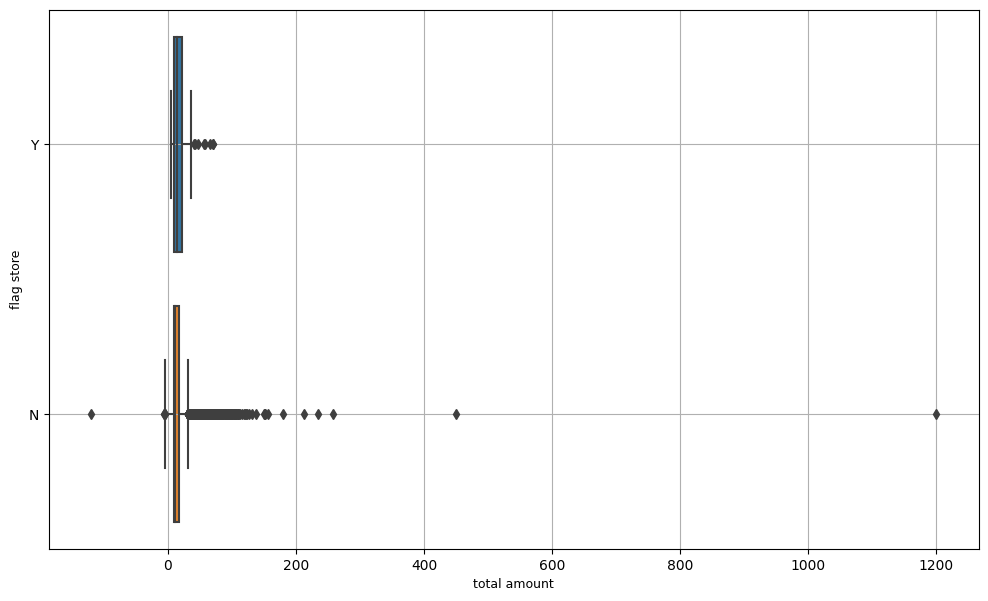

In [5]:
flag_order = ['Y', 'N']

df_sorted_total_amount = df
df_sorted_total_amount['total_amount'] = df_sorted_total_amount['total_amount'].sort_values(ascending=True)
df_sorted_total_amount

plt.figure(figsize=(12,7))
ax = sns.boxplot(x=df_sorted_total_amount['total_amount'],
                 y=df_sorted_total_amount['store_and_fwd_flag'],
                 order=flag_order)

#ax.set_xticklabels(df_sorted_total_amount['total_amount'], fontsize = 16)
#ax.set_yticklabels(df_sorted_total_amount['store_and_fwd_flag'], fontsize = 16)
plt.xlabel('total amount', fontsize=9)
plt.ylabel('flag store', fontsize=9)

plt.grid()

**[ 🇧🇷 PT | 🇺🇸 EN ]**

#### 1. Distribuição de distâncias e tarifas

- A maioria das corridas possui distância curta (até 2–3 milhas, 10-20 minutos), refletindo o perfil urbano de deslocamentos.

- Corridas muito longas existem, mas são outliers — muitas vezes associadas a aeroportos (JFK, Newark).

- As tarifas acompanham esse padrão: valores concentrados em corridas curtas, mas com uma cauda longa para valores altos.

#### 2. Distribuição por horário do dia

- Há picos claros no início da manhã e também no final da tarde/noite.

#### Resumo Final:
>A EDA sugere que o **comportamento das corridas é altamente concentrado em distâncias curtas, tarifas baixas e passageiros únicos**, mas com outliers significativos que precisam ser tratados. Além disso, tempo (hora/dia) e localização são dimensões cruciais para explicar variação no preço. Essas descobertas indicam variáveis-chave que fortalecem o modelo preditivo: distância, horário, localização, taxa-base, e tipo de pagamento.

---

**[ 🇺🇸 EN ]**

#### 1. Distance and Fare Distribution

- Most trips are short-distance (up to 2–3 miles, 10–20 minutes), reflecting the urban profile of travel in the city.

- Very long trips exist, but they are outliers — often associated with airports (JFK, Newark).

- Fares follow the same pattern: values concentrated in short trips, but with a long tail for higher amounts.

#### 2. Distribution by Time of Day

- There are clear peaks in the early morning and also in the late afternoon/evening.

#### Final Summary:

>The EDA suggests that **trip behavior is highly concentrated in short distances, low fares, and single passengers**, but with significant outliers that need to be addressed. In addition, time (hour/day) and location are crucial dimensions to explain price variation. These findings highlight key variables that strengthen the predictive model: distance, time, location, base rate, and payment type.

#### **VERIFICAÇÃO E TRATAMENTO DE OUTLIERS** / OUTLIER DETECTION AND TREATMENT

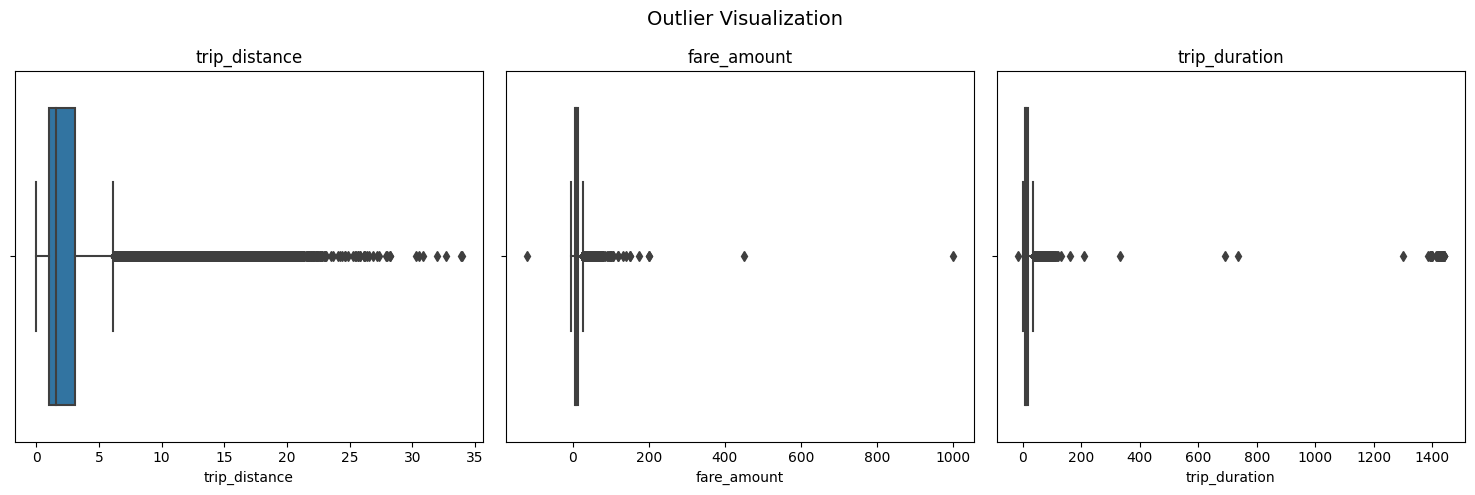

In [6]:
column_list = ['trip_distance','fare_amount','trip_duration']

fig, axes = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Outlier Visualization', fontsize=14)

for i, column in enumerate(column_list):
    sns.boxplot(ax=axes[i],
                x=df[column])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [7]:
def calculate_iqr_limits(df, column):
    """
    Calculate the interquartile range (IQR) and derive lower and upper limits
    for outlier detection on a given numeric column of a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing the data.
    column : str
        Name of the numeric column to calculate IQR and limits.

    Returns
    -------
    q1 : float
        First quartile (25th percentile) of the column.
    q3 : float
        Third quartile (75th percentile) of the column.
    iqr : float
        Interquartile range (Q3 - Q1).
    upper_limit : float
        Upper threshold for detecting outliers (Q3 + 1.5 * IQR).
    lower_limit : float
        Lower threshold for detecting outliers (Q1 - 1.5 * IQR).
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    return q1, q3, iqr, upper_limit, lower_limit

def view_outliers(df):
    """
    Identify and display the number and percentage of outliers 
    for all numeric columns in a DataFrame using IQR limits.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame to be analyzed.

    Returns
    -------
    None
        Prints the number and percentage of outliers for each numeric column.
    """
    numeric_columns = df.select_dtypes(include=['number']).columns
    total_dataset = df.shape[0]

    for column in numeric_columns:
        q1, q3, iqr, upper_limit, lower_limit = calculate_iqr_limits(df, column)

        df_outliers = df[(df[column] >= upper_limit) | (df[column] <= lower_limit)]

        total_outliers = df_outliers.shape[0]
        percentage_outliers = total_outliers / total_dataset

        if 0 < percentage_outliers < 1:
            print(f'[ {column} ] >> {total_outliers} outliers :: {percentage_outliers * 100:.2f}%')

print('>> contagem de outliers / outliers count \n')
view_outliers(df)

>> contagem de outliers / outliers count 

[ passenger_count ] >> 2291 outliers :: 10.09%
[ trip_distance ] >> 2527 outliers :: 11.13%
[ payment_type ] >> 46 outliers :: 0.20%
[ fare_amount ] >> 2145 outliers :: 9.45%
[ extra ] >> 103 outliers :: 0.45%
[ tip_amount ] >> 1186 outliers :: 5.22%
[ total_amount ] >> 2161 outliers :: 9.52%
[ trip_duration ] >> 1228 outliers :: 5.41%


In [8]:
print('>> tratamento de outliers / outliers treatment \n')
def fix_data(df, column, factor_limit):
    """
    Adjust extreme values of a given numeric column by capping outliers 
    based on a custom factor of the interquartile range (IQR). 
    Negative values are replaced with zero.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame to be modified.
    column : str
        Name of the numeric column to be adjusted.
    factor_limit : float
        Custom multiplier applied to IQR to define the upper limit.

    Returns
    -------
    None
        Modifies the DataFrame in place and prints summary statistics 
        for the adjusted column.
    """
    q1, q3, iqr, upper_limit, lower_limit = calculate_iqr_limits(df, column)
    superior_limit = q3 + factor_limit * iqr #Define a custom upper limit

    print(f'>> {column} column adjustment')
    print(f'>> Q3: {q3:.2f}')
    print(f'>> IQR: {iqr:.2f}')
    print(f'>> Superior Limit (custom): {superior_limit:.2f}\n')

    df.loc[df[column] < 0, column] = 0
    df.loc[df[column] > superior_limit, column] = superior_limit

    display(df[column].describe())
    print()

for column in column_list: fix_data(df = df, column = column, factor_limit = 4)

>> tratamento de outliers / outliers treatment 

>> trip_distance column adjustment
>> Q3: 3.06
>> IQR: 2.07
>> Superior Limit (custom): 11.34



count    22699.000000
mean         2.689457
std          2.786132
min          0.000000
25%          0.990000
50%          1.610000
75%          3.060000
max         11.340000
Name: trip_distance, dtype: float64


>> fare_amount column adjustment
>> Q3: 14.50
>> IQR: 8.00
>> Superior Limit (custom): 46.50



count    22699.000000
mean        12.674612
std          9.697492
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         46.500000
Name: fare_amount, dtype: float64


>> trip_duration column adjustment
>> Q3: 18.38
>> IQR: 11.73
>> Superior Limit (custom): 65.30



count    22699.000000
mean        14.348042
std         11.358792
min          0.000000
25%          6.650000
50%         11.180000
75%         18.380000
max         65.300000
Name: trip_duration, dtype: float64

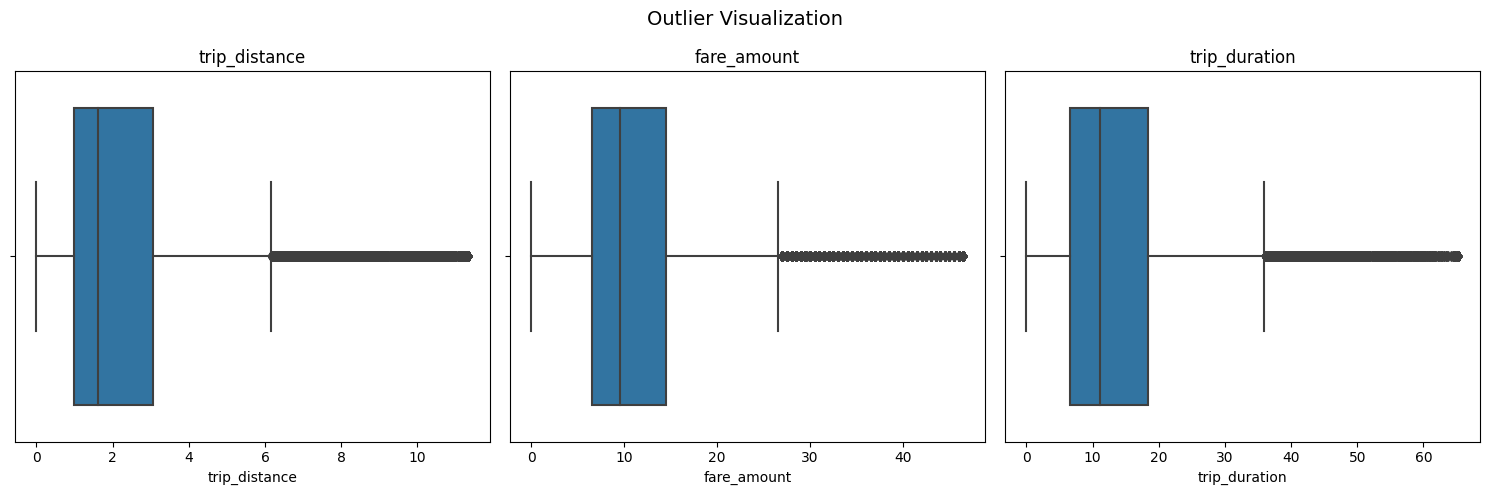

In [9]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Outlier Visualization', fontsize=14)

for i, column in enumerate(column_list):
    sns.boxplot(ax=axes[i],
                x=df[column])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

**[ 🇧🇷 PT | 🇺🇸 EN ]**

O **dataset apresenta uma quantidade significativa de outliers** em variáveis numéricas.
Em vez de remover esses registros, os **valores extremos foram ajustados (capping) para quatro vezes o intervalo interquartil (IQR)** acima do terceiro quartil.
Além disso, valores negativos foram substituídos por zero, garantindo maior consistência dos dados.

---

**[ 🇺🇸 EN ]**

The **dataset contains a considerable number of outliers** across its numerical variables.
Rather than removing these records, **extreme values were capped at four times the interquartile range (IQR)** above the third quartile.
In addition, negative values were replaced with zero to ensure greater data consistency.

## **VERIFICAÇÃO DE PREMISSAS** / ASSUMPTION CHECKING

**<a href="#NEW-YORK-CITY-YELLOW-TAXI---TRIP-FARE-PREDICTION">VOLTAR PARA O INÍCIO / BACK TO HOME</a>**

#### **1. RELAÇÕES ENTRE VARIÁVEIS** / RELATIONSHIPS BETWEEN VARIABLES

**[ 🇧🇷 PT | 🇺🇸 EN ]**

Nesta etapa, analisamos como as variáveis se relacionam entre si.
Esse tipo de avaliação permite verificar, por exemplo, se a tarifa apresenta correlação positiva com a distância percorrida, bem como entender de que forma o horário do dia influencia o valor final da corrida.

---

**[ 🇺🇸 EN ]**

At this stage, we analyze how variables relate to each other.
This evaluation makes it possible to verify, for instance, whether the fare shows a positive correlation with trip distance, as well as to understand how the time of day impacts the final trip price.

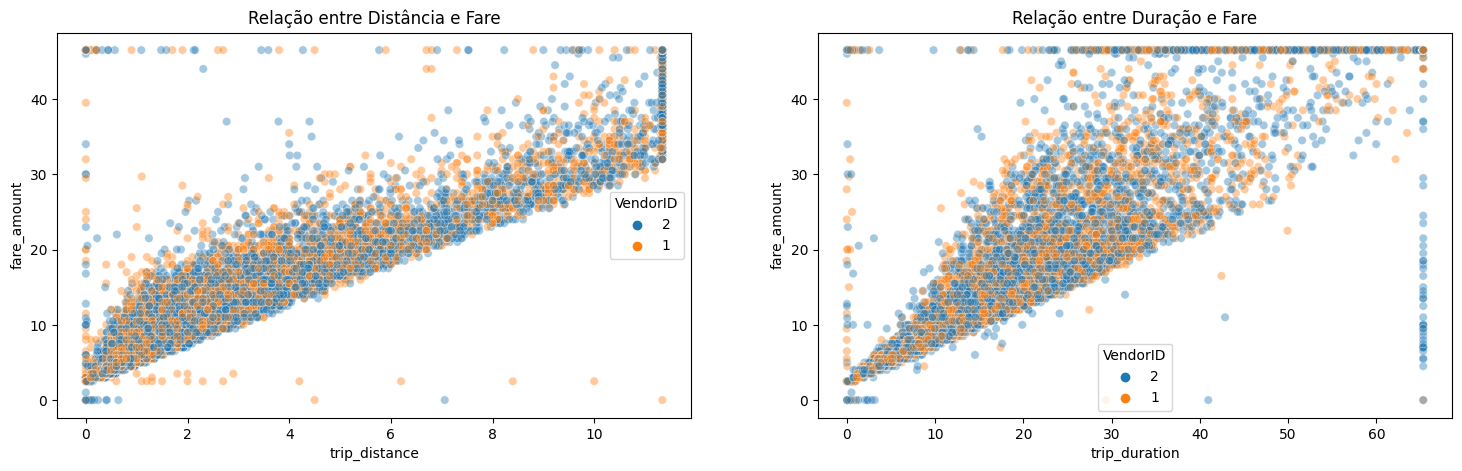

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

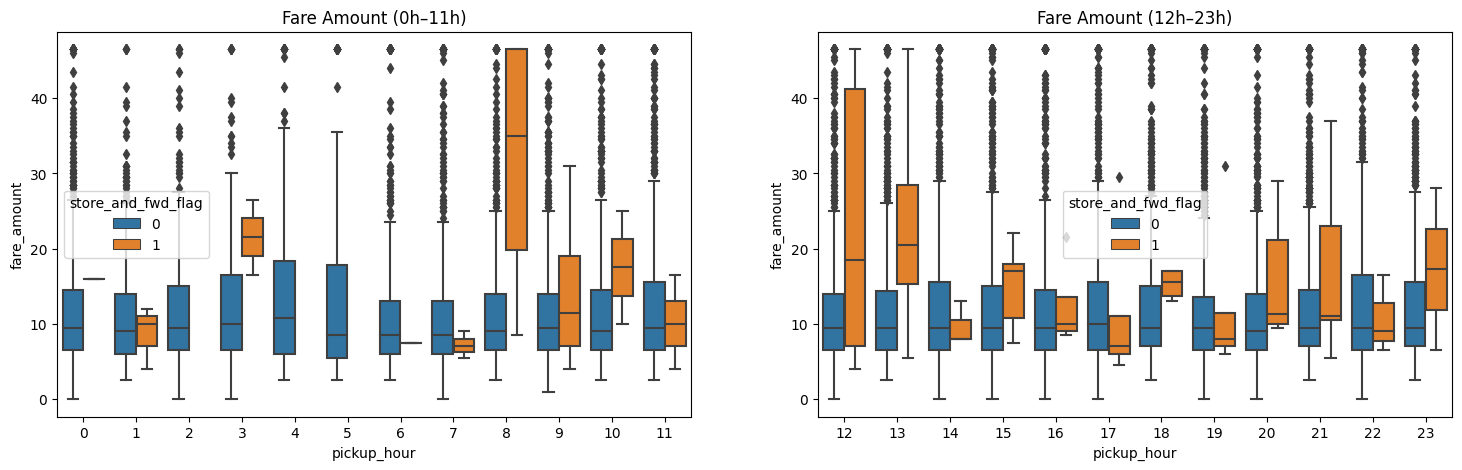

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [10]:
#----------------------------------------
# Preparação de dados para amostragem:
# PT: Criação de cópia do dataset, transformação da flag store_and_fwd (N/Y → 0/1) e amostragem de 20.000 registros
# EN: Dataset copy, transformation of store_and_fwd flag (N/Y → 0/1), and random sampling of 20,000 records
#----------------------------------------

df2 = df.copy()
df2['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

#df_sample = df2[df2['store_and_fwd_flag'] == 1]
df_sample = df2.sample(20000, random_state=42)

#----------------------------------------
# Análises exploratórias com scatterplots:
# PT: Relação entre variáveis contínuas (distância/duração da corrida) e tarifa, diferenciadas por fornecedor
# EN: Relationship between continuous variables (trip distance/duration) and fare amount, differentiated by vendor
#----------------------------------------

fig, axes = plt.subplots(1,2, figsize=(18,5))

plt.figure(figsize=(5,5))
sns.scatterplot(
    ax=axes[0],
    x=df_sample['trip_distance'],
    y=df_sample['fare_amount'],
    hue=df_sample['VendorID'],
    data=df_sample,
    alpha=0.4)
axes[0].set_title("Relação entre Distância e Fare")

plt.figure(figsize=(5,5))
sns.scatterplot(
    ax=axes[1],
    x=df_sample['trip_duration'],
    y=df_sample['fare_amount'],
    hue=df_sample['VendorID'],
    data=df_sample,
    alpha=0.4)
axes[1].set_title("Relação entre Duração e Fare")

#----------------------------------------
# Análises temporais com boxplots:
# PT: Distribuição das tarifas por hora do dia, segmentadas pela flag store_and_fwd, separando manhã (0–11h) e tarde/noite (12–23h)
# EN: Distribution of fares by pickup hour, segmented by store_and_fwd flag, split into morning (0–11h) and afternoon/evening (12–23h)
#----------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Manhã (0–11h)
plt.figure(figsize=(5,5))
sns.boxplot(ax=axes[0],
            data=df_sample[(df_sample['pickup_hour'] >= 0) & (df_sample['pickup_hour'] <= 11)],
            x="pickup_hour",
            y="fare_amount",
            hue="store_and_fwd_flag")
axes[0].set_title("Fare Amount (0h–11h)")

# Tarde/Noite (12–23h)
plt.figure(figsize=(5,5))
sns.boxplot(ax=axes[1],
            data=df_sample[(df_sample['pickup_hour'] >= 12) & (df_sample['pickup_hour'] <= 23)],
            x="pickup_hour",
            y="fare_amount",
            hue="store_and_fwd_flag")
axes[1].set_title("Fare Amount (12h–23h)")

plt.tight_layout()
plt.show()

In [11]:
#----------------------------------------
# Verificação da distribuição de variáveis categóricas:
# PT: Contagem de registros para as categorias store_and_fwd_flag e VendorID no dataset amostrado
# EN: Count of records for store_and_fwd_flag and VendorID categories in the sampled dataset
#----------------------------------------

display(df_sample['store_and_fwd_flag'].value_counts())
display(df_sample['VendorID'].value_counts())

store_and_fwd_flag
0    19913
1       87
Name: count, dtype: int64

VendorID
2    11135
1     8865
Name: count, dtype: int64

#### **2. CORRELAÇÃO ENTRE VARIÁVEIS** / CORRELATION BETWEEN VARIABLES

**[ 🇧🇷 PT | 🇺🇸 EN ]**

A análise por meio de uma matriz de correlação permite identificar relações fortes entre variáveis.
Esse processo é fundamental para:

- Detectar redundâncias entre atributos;
- Avaliar riscos de multicolinearidade em determinados modelos estatísticos;
- Justificar decisões quanto à manutenção ou exclusão de variáveis durante a preparação dos dados.

---

**[ 🇺🇸 EN ]**

The use of a correlation matrix makes it possible to identify strong relationships between variables.
This analysis is essential to:

- Detect potential redundancies among features;
- Assess risks of multicollinearity in certain statistical models;
- Justify decisions regarding the retention or removal of variables during data preparation.

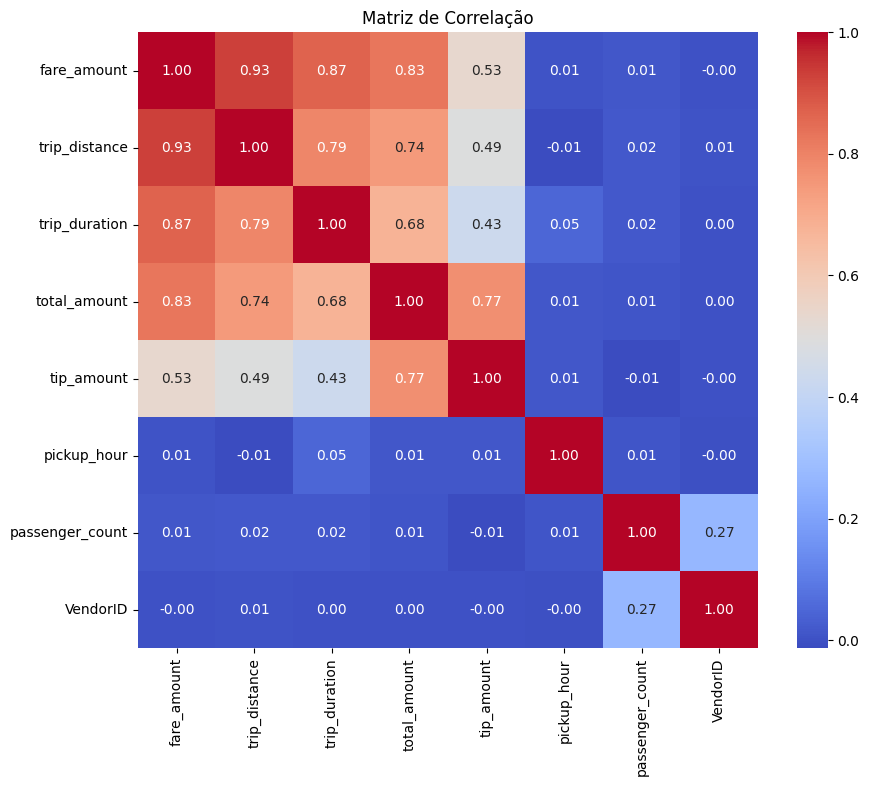

In [12]:
#----------------------------------------
# PT: Cálculo e visualização da matriz de correlação entre variáveis numéricas selecionadas
#     O heatmap ajuda a identificar relações lineares fortes (positivas ou negativas)
#     que podem influenciar a modelagem
#
# EN: Calculation and visualization of the correlation matrix between selected numerical variables
#     The heatmap helps identify strong linear relationships (positive or negative)
#     that may impact modeling
#----------------------------------------

plt.figure(figsize=(10,8))
corr = df[['fare_amount','trip_distance','trip_duration','total_amount',
           'tip_amount','pickup_hour','passenger_count','VendorID']].corr()

sns.heatmap(corr,
            annot=True,
            cmap='coolwarm',
            fmt=".2f")

plt.title("Matriz de Correlação")
plt.show()

**[ 🇧🇷 PT | 🇺🇸 EN ]**

>As variáveis **trip_duration e trip_distance apresentam alta correlação com a variável alvo fare_amount**.
Além disso, ambas também estão fortemente correlacionadas entre si, com um coeficiente de Pearson de 0.79.

Vale lembrar que, em modelos de regressão linear, a multicolinearidade entre variáveis preditoras pode comprometer a interpretação estatística dos coeficientes.
Por outro lado, **em contextos de modelagem preditiva, variáveis correlacionadas ainda podem ser utilizadas** se o foco principal for a acurácia do modelo e não a interpretação dos parâmetros.

Dessa forma, optaremos por testar o modelo incluindo ambas as variáveis, mesmo com a correlação existente, considerando que o objetivo é prever fare_amount de forma mais precisa.

---

**[ 🇺🇸 EN ]**

>The **variables trip_duration and trip_distance show a strong correlation with the target variable fare_amount**.
Additionally, they are highly correlated with each other, with a Pearson correlation coefficient of 0.79.

It is important to note that in linear regression models, multicollinearity among predictors can undermine the statistical interpretability of coefficients.
However, **in predictive modeling contexts, correlated predictors may still be included** if the primary goal is model accuracy rather than coefficient interpretation.

Therefore, we will test the model using both variables, despite their correlation, since the main objective is to predict fare_amount as accurately as possible.

#### **3. MULTICOLINEARIDADE (VIF)** / MULTICOLLINEARITY (VIF)

**[ 🇧🇷 PT | 🇺🇸 EN ]**

Modelos lineares partem do pressuposto de que as variáveis independentes não apresentam alta colinearidade.
O VIF (Variance Inflation Factor) é a métrica utilizada para avaliar esse efeito:

- Valores próximos de 1 indicam baixa colinearidade;
- Valores entre 5 e 10 sugerem moderada a alta multicolinearidade;
- Valores acima de 10 indicam multicolinearidade severa, podendo comprometer a interpretação dos coeficientes.

---

**[ 🇺🇸 EN ]**

Linear models assume that independent variables are not highly collinear.
The VIF (Variance Inflation Factor) is the metric used to measure this effect:

- Values close to 1 indicate low collinearity;
- Values between 5 and 10 suggest moderate to high multicollinearity;
- Values above 10 indicate severe multicollinearity, which may compromise coefficient interpretability.

In [13]:
#----------------------------------------
# PT: Cálculo do Fator de Inflação da Variância (VIF) para verificar multicolinearidade
#     entre as variáveis independentes selecionadas. Valores altos de VIF indicam
#     forte correlação entre preditores, o que pode comprometer modelos lineares
#
# EN: Calculation of Variance Inflation Factor (VIF) to check multicollinearity
#     among selected independent variables. High VIF values indicate strong
#     correlation between predictors, which may harm linear models
#----------------------------------------

X_vif = df[['trip_distance','trip_duration','pickup_hour','pickup_month']].dropna()
X_vif_const = add_constant(X_vif)

vif = pd.DataFrame()
vif["feature"] = X_vif_const.columns
vif["VIF"] = [variance_inflation_factor(X_vif_const.values, i) 
              for i in range(X_vif_const.shape[1])]
display(vif)

,feature,VIF
0,const,10.535022
1,trip_distance,2.714490
2,trip_duration,2.723373
3,pickup_hour,1.009441
4,pickup_month,1.002439


**[ 🇧🇷 PT | 🇺🇸 EN ]**

- **trip_distance (2.71) e trip_duration (2.72)**: valores baixos, o que confirma que não há redundância crítica entre essas variáveis.
- **pickup_hour (1.01) e pickup_month (1.00)**: praticamente sem colinearidade, reforçando que ambas trazem informações únicas ao modelo.
- const (10.53): aparece acima do limite de 10, mas isso é esperado. O termo constante não influencia a interpretação prática da multicolinearidade entre variáveis preditoras, podendo ser desconsiderado nesse contexto.

>Conclusão: todas as **variáveis explicativas estão dentro de níveis aceitáveis**, garantindo estabilidade estatística e interpretabilidade dos coeficientes do modelo linear.

---

**[ 🇺🇸 EN ]**

- **trip_distance (2.71) and trip_duration (2.72)**: low values, confirming no critical redundancy between these predictors.
- **pickup_hour (1.01) and pickup_month (1.00)**: almost no collinearity, showing that both add unique information to the model.
- const (10.53): exceeds the threshold of 10, but this is expected. The constant term does not affect practical interpretation of predictor multicollinearity and can be disregarded in this analysis.

>Conclusion: all **explanatory variables fall within acceptable levels**, ensuring statistical stability and interpretability of linear model coefficients.

#### **4. ANÁLISE DE ERROS E HETEROCEDASTICIDADE** / ERROR ANALYSIS AND HETEROSCEDASTICITY

**[ 🇧🇷 PT | 🇺🇸 EN ]**

Antes de confiar nos resultados de regressões lineares, é essencial avaliar os resíduos do modelo. Os principais pontos de verificação incluem:

- Se os resíduos estão distribuídos em torno de zero, sem viés sistemático.
- Se não há padrões de variância (heterocedasticidade), ou seja, se a dispersão dos erros permanece aproximadamente constante ao longo das previsões.
- A presença de heterocedasticidade ou padrões residuais indica violação dos pressupostos da regressão linear. Nessas situações, torna-se recomendável utilizar modelos mais robustos, como LightGBM ou outros métodos baseados em árvores de decisão.

---

**[ 🇺🇸 EN ]**

Before relying on linear regression results, it is essential to evaluate the model’s residuals. Key checks include:

- Whether residuals are centered around zero, without systematic bias.
- Whether there are variance patterns (heteroscedasticity), meaning that the error spread remains approximately constant across predictions.
- The presence of heteroscedasticity or residual patterns indicates violations of linear regression assumptions. In such cases, it is advisable to adopt more robust models, such as LightGBM or other tree-based methods.

In [14]:
#----------------------------------------
# PT: Preparação dos dados para modelagem:
#     - Remoção de colunas irrelevantes ou redundantes
#     - Tratamento de valores ausentes nas variáveis principais
#     - Criação de variáveis dummies para categóricas
#     - Separação entre variáveis independentes (X) e dependente (y)
#     - Divisão em treino e teste (80/20)
#     - Normalização com StandardScaler
#     - Treinamento de um modelo de Regressão Linear
#     - Predição e cálculo dos resíduos
#
# EN: Data preparation for modeling:
#     - Removing irrelevant or redundant columns
#     - Handling missing values in key variables
#     - Creating dummy variables for categorical features
#     - Splitting into independent (X) and dependent (y) variables
#     - Train/test split (80/20)
#     - Normalization with StandardScaler
#     - Training a Linear Regression model
#     - Prediction and calculation of residuals
#----------------------------------------

df1 = df.drop(columns=[
    'Unnamed: 0','tpep_pickup_datetime','tpep_dropoff_datetime',
    'store_and_fwd_flag','PULocationID','DOLocationID','payment_type','extra','mta_tax','tip_amount',
    'tolls_amount','improvement_surcharge','total_amount','is_weekend'], axis=1)

df1 = df1.dropna(subset=['RatecodeID','passenger_count','VendorID','pickup_hour',
                         'day_name','pickup_month','fare_amount'])

df1 = pd.get_dummies(df1, drop_first=True)

X = df1.drop(columns=['fare_amount'], axis=1)
y = df1['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
y_pred = linreg.predict(X_test_scaled)

residuals = y_test - y_pred

In [15]:
#----------------------------------------
# PT: Avaliação do modelo de Regressão Linear:
#     - Predições no conjunto de treino e cálculo de métricas (R², MAE, MSE, RMSE)
#     - Predições no conjunto de teste e cálculo das mesmas métricas
#     - Criação de um DataFrame com valores reais, preditos e resíduos
#
# EN: Evaluation of the Linear Regression model:
#     - Predictions on the training set and computation of metrics (R², MAE, MSE, RMSE)
#     - Predictions on the test set and computation of the same metrics
#     - Creation of a DataFrame with actual, predicted, and residual values
#----------------------------------------

y_pred_train = linreg.predict(X_train_scaled)

print('Train Metrics')
print('R2:  ', r2_score(y_train, y_pred_train).round(4))
print('MAE: ', mean_absolute_error(y_train, y_pred_train).round(4))
print('MSE: ', mean_squared_error(y_train, y_pred_train).round(4))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)).round(4))

print()

X_test_scaled = scaler.transform(X_test)
y_pred_test = linreg.predict(X_test_scaled)

print('Test Metrics')
print('R2:  ', r2_score(y_test, y_pred_test).round(4))
print('MAE: ', mean_absolute_error(y_test,y_pred_test).round(4))
print('MSE: ', mean_squared_error(y_test, y_pred_test).round(4))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)).round(4))

print()

print('Results')
results = pd.DataFrame(data = {'actual': y_test.values,
                               'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

Train Metrics
R2:   0.9443
MAE:  0.8496
MSE:  5.315
RMSE: 2.3054

Test Metrics
R2:   0.9429
MAE:  0.831
MSE:  5.0648
RMSE: 2.2505

Results


,actual,predicted,residual
0,12.5,10.951285,1.548715
1,6.0,6.674611,-0.674611
2,12.0,10.442029,1.557971
3,20.5,21.063950,-0.563950
4,14.0,14.918955,-0.918955


## **AVALIAÇÃO RÁPIDA DO MODELO** / FAST MODEL EVALUATION
**<a href="#NEW-YORK-CITY-YELLOW-TAXI---TRIP-FARE-PREDICTION">VOLTAR PARA O INÍCIO / BACK TO HOME</a>**

**[ 🇧🇷 PT | 🇺🇸 EN ]**

O desempenho do modelo apresenta **resultados consistentes** tanto em treino quanto em teste, **indicando baixo viés e ausência de overfitting**.

Treino:
- **R² = 0.9443**: O modelo explica aproximadamente **94,4%** da variância da variável fare_amount.
- **MAE = 0.8496**: O erro absoluto médio é de menos de `$ 1`, sugerindo boa precisão nas previsões.
- **RMSE = 2.3054**: O erro quadrático médio indica que, em média, a magnitude do erro é de cerca de `$ 2,30`.

Teste:
- **R² = 0.9429**: O modelo mantém sua capacidade explicativa em dados nunca vistos, confirmando generalização adequada.
- **MAE = 0.831**: O erro absoluto médio permanece estável em relação ao treino, reforçando a robustez do modelo.
- **MSE = 2.2505**: O valor é muito próximo ao obtido no treino, mostrando consistência.

No contexto do problema, o MAE é particularmente relevante, pois indica que a maioria dos erros está em torno de `$ 1` — um nível aceitável de variação para previsões de tarifas de táxi.

---

**[ 🇺🇸 EN ]**

The model demonstrates **consistent performance** on both training and test datasets, **suggesting low bias and no signs of overfitting**.

Training:
- **R² = 0.9443**: The model explains approximately **94.4%** of the variance in the fare_amount variable.
- **MAE = 0.8496**: The mean absolute error is less than `$ 1`, indicating high predictive accuracy.
- **MSE = 2.3054**: On average, the magnitude of the prediction error is about `$ 2.30`.

Testing:
- **R² = 0.9429**:  The model retains its explanatory power on unseen data, confirming good generalization.
- **MAE = 0.831**:  The mean absolute error remains stable compared to training, reinforcing the model’s robustness.
- **RMSE = 2.2505**:  Very close to the training value, which indicates consistency.

In this context, the MAE is particularly meaningful, as it shows that most prediction errors are around `$ 1` — an acceptable level of variation for taxi fare forecasting.

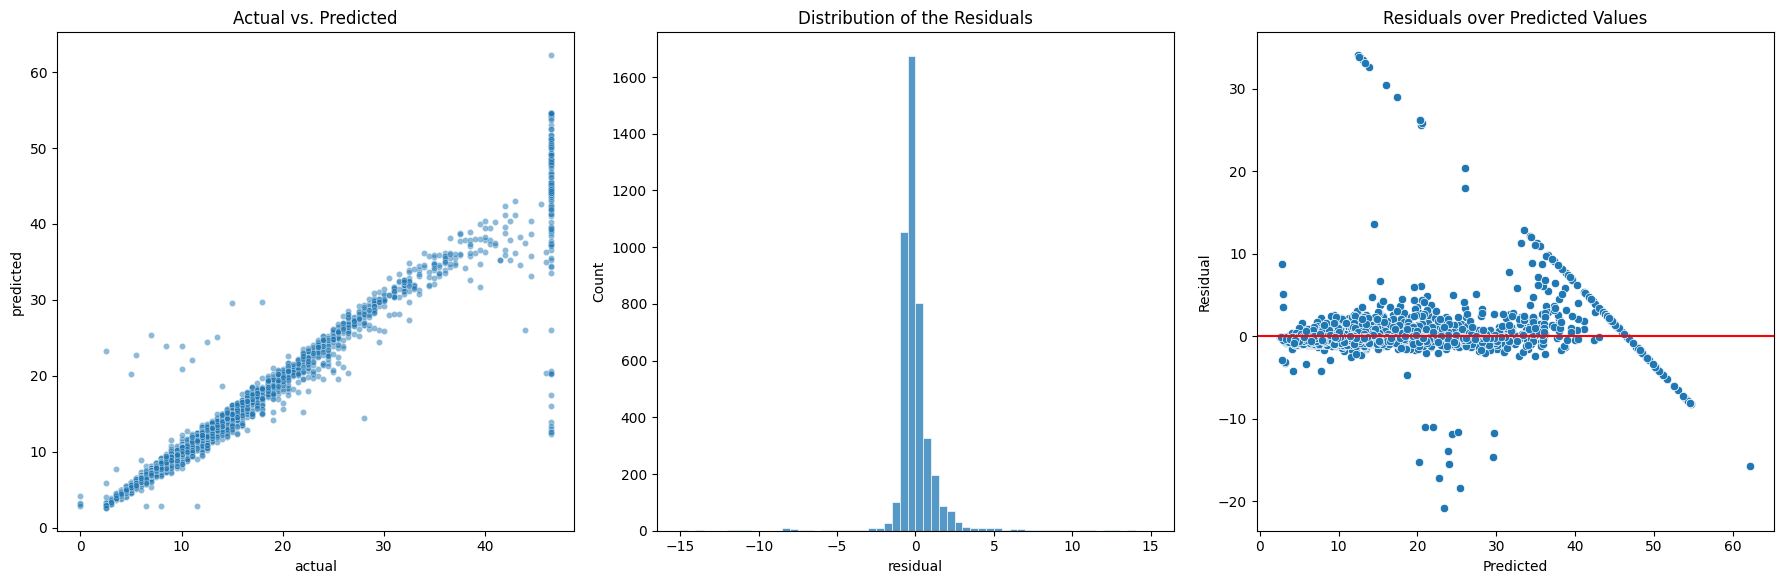

In [16]:
#----------------------------------------
# PT: Visualização do desempenho do modelo:
#     - Gráfico de dispersão entre valores reais e previstos (idealmente próximos da linha 45°)
#     - Histograma da distribuição dos resíduos (esperado próximo de normal, centrado em 0)
#     - Gráfico de dispersão dos resíduos em relação aos valores previstos
#       (idealmente sem padrão definido, indicando erros aleatórios)
#
# EN: Model performance visualization:
#     - Scatter plot of actual vs. predicted values (ideally close to the 45° line)
#     - Histogram of residual distribution (expected near normal, centered at 0)
#     - Scatter plot of residuals vs. predicted values
#       (ideally with no clear pattern, suggesting random errors)
#----------------------------------------

fig, axes = plt.subplots(1,3, figsize=(18,6))
sns.set(style = 'whitegrid')

sns.scatterplot(
    x='actual',
    y='predicted',
    data=results,
    s=20,
    alpha=0.5,
    ax=axes[0])

axes[0].set_title('Actual vs. Predicted')

sns.histplot(results['residual'],
             bins = np.arange(-15,15.5,0.5),
             ax = axes[1])
axes[1].set_title('Distribution of the Residuals')

sns.scatterplot(
    x = 'predicted',
    y = 'residual',
    data = results,
    ax = axes[2]
)
axes[2].axhline(0, c='red')
axes[2].set_title('Residuals over Predicted Values')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Residual')

plt.tight_layout()
plt.show()

#### **ANÁLISE DOS RESÍDUOS** / RESIDUAL ANALYSIS

**[ 🇧🇷 PT | 🇺🇸 EN ]**

A **distribuição dos resíduos é aproximadamente normal**, com média de -0.015.
Os resíduos representam a parcela da variância da variável resposta que não foi explicada pelo modelo.

- Uma distribuição normal em torno de zero é desejável, pois indica que os erros estão bem distribuídos e não apresentam viés sistemático.
- Neste caso, os resíduos estão uniformemente distribuídos acima e abaixo de zero, **reforçando a qualidade do ajuste**.
- A principal exceção está nas linhas inclinadas do canto superior esquerdo ao inferior direito, que refletem limites imputados:
    - Tarifa máxima de `$ 46.50`.
    - Tarifa fixa de `$ 52.00` aplicada em corridas para o aeroporto JFK.

Esses padrões não comprometem a validade do modelo, mas representam características próprias do sistema tarifário.

---

**[ 🇺🇸 EN ]**

The **residual distribution is approximately normal**, with a mean of -0.015.
Residuals represent the portion of variance in the outcome variable that is not explained by the model.
- A normal distribution centered around zero is desirable, as it indicates that errors are well balanced and unbiased.
- In this case, residuals are evenly distributed above and below zero, **reinforcing the model’s fit quality**.
- The main exceptions are the sloping lines from the upper-left to the lower-right corner, which correspond to imposed fare rules:
    - Maximum capped fare of `$ 46.50`.
    - Flat rate of `$ 52.00` for JFK airport trips.

These patterns do not undermine the model’s validity but rather reflect structural constraints of the taxi fare system.

#### **IDEIAS INICIAIS** / INITIAL IDEAS

**[ 🇧🇷 PT | 🇺🇸 EN ]**

A análise dos resultados e dos resíduos fornece insights importantes sobre a adequação do modelo e a qualidade das previsões:

#### PADRÕES BÁSICOS
- As distribuições de **distância e duração** confirmam a predominância de corridas curtas, reforçando o perfil urbano do dataset.  
- O modelo conseguiu capturar bem essa dinâmica, mantendo previsões próximas ao valor real na maior parte dos casos.

#### AJUSTE DO MODELO
- O gráfico **Actual vs Predicted** mostra alinhamento consistente próximo da diagonal, indicando boa capacidade de previsão.  
- Observam-se alguns desvios em corridas de valores mais altos, o que pode refletir **menor representatividade desses casos no dataset**.

#### ANÁLISE DE RESÍDUOS
- A **distribuição dos resíduos** é centrada em torno de zero, com leve assimetria, mas sem grandes distorções — evidência de que o modelo não apresenta vieses sistemáticos.  
- O gráfico de **resíduos vs valores previstos** confirma a presença de **heterocedasticidade**: a dispersão dos erros aumenta para tarifas maiores.  
- Apesar disso, a maioria dos resíduos se concentra em um intervalo reduzido, próximo de zero, reforçando a estabilidade do modelo.

#### CONCLUSÕES
- O modelo é **robusto e confiável**, ainda que menos preciso em corridas de valores extremos.  
- A heterocedasticidade reforça a escolha de algoritmos baseados em árvores (HistGBR, XGBoost), que lidam melhor com variâncias não constantes.  
- Em termos de negócio, o erro médio em torno de **1 unidade monetária** é pouco relevante frente ao valor médio das corridas, o que valida a aplicabilidade do modelo.

---

**[ 🇺🇸 EN ]**

The analysis of results and residuals provides key insights into the model’s adequacy and prediction quality:

#### BASIC PATTERNS
- The **distance and duration distributions** confirm the predominance of short trips, reinforcing the dataset’s urban profile.  
- The model effectively captures this behavior, keeping predictions close to actual values in most cases.

#### MODEL FIT
- The **Actual vs Predicted** plot shows strong alignment near the diagonal, evidencing accurate predictions.  
- Deviations are more evident for higher fares, likely due to their **lower representation in the dataset**.

#### RESIDUAL ANALYSIS
- The **residual distribution** is centered around zero, with slight skewness but no critical distortions — evidence of no major systematic bias.  
- The **residuals vs predicted values** plot reveals **heteroscedasticity**: error variance increases with fare amount.  
- Nonetheless, most residuals are concentrated in a narrow range around zero, supporting the model’s stability.

#### CONCLUSIONS
- The model is **robust and reliable**, though slightly less accurate for extreme fare values.  
- The heteroscedasticity observed justifies the choice of tree-based algorithms (HistGBR, XGBoost), which better handle non-constant variance.  
- From a business standpoint, the average error of about **1 monetary unit** is negligible compared to the average fare value, validating the model’s practical applicability.


#### **INTERPRETAÇÃO DOS COEFICIENTES** / COEFFICIENT INTERPRETATION

In [17]:
#----------------------------------------
# PT: Criação de DataFrame com os coeficientes do modelo:
#     - Cada linha representa uma variável independente (feature)
#     - O valor do coeficiente indica o impacto na variável alvo (fare_amount)
#     - Valores positivos: aumentam a previsão da tarifa
#     - Valores negativos: reduzem a previsão da tarifa
#     - A ordenação (descending) ajuda a identificar as variáveis mais influentes
#
# EN: Creating a DataFrame with model coefficients:
#     - Each row represents an independent variable (feature)
#     - The coefficient value shows its impact on the target variable (fare_amount)
#     - Positive values: increase the fare prediction
#     - Negative values: decrease the fare prediction
#     - Sorting (descending) highlights the most influential variables
#----------------------------------------

coefficients = pd.DataFrame({
    'feature': X.columns,
    'coefficient': linreg.coef_
}).sort_values(by="coefficient", ascending=False)

coefficients

,feature,coefficient
1,trip_distance,5.786106
2,trip_duration,3.266512
6,RatecodeID_2,1.480493
9,RatecodeID_5,0.953775
7,RatecodeID_3,0.448543
10,RatecodeID_99,0.323162
8,RatecodeID_4,0.166173
15,day_name_tue,0.051309
16,day_name_wed,0.029931
14,day_name_thu,0.027019


**[ 🇧🇷 PT | 🇺🇸 EN ]**

#### Análise dos Coeficientes (Referência Padronizada)

| Variável        | Coeficiente | Interpretação resumida                                                                              |
|:---------------:|:-----------:|-----------------------------------------------------------------------------------------------------|
| trip_distance   | 5.79        | Forte impacto positivo - corridas mais longas aumentam o valor.                                     |
| trip_duration   | 3.27        | Impacto positivo relevante - viagens mais demoradas elevam a tarifa.                                |
| RatecodeID_*    | 0.17–1.48   | Efeito positivo adicional conforme o tipo de tarifa.                                                |
| day_name_tue/…  | ±0.05       | Impactos semanais pequenos; terça, quarta e quinta levemente positivos, sábado e domingo negativos. |
| pickup_month    | 0.01        | Pequeno aumento associado à variação mensal.                                                        |
| pickup_hour     | -0.0016     | Impacto mínimo negativo do horário.                                                                 |
| passenger_count | -0.023      | Mais passageiros reduzem discretamente o valor médio.                                               |
| VendorID_2      | -0.052      | Pequena redução associada a esse fornecedor.                                                        |

#### **Observação**

Os coeficientes foram obtidos via **processo de padronização (standardization)** e são **valores de referência relativos**.  
A interpretação em **unidades originais** exige dividir cada coeficiente pelo **desvio padrão da variável** correspondente.  

---

**[ 🇺🇸 EN ]**

#### Coefficient Analysis (Standardized Reference)

| Variable        | Coefficient | Short Interpretation                                               |
|:---------------:|:-----------:|--------------------------------------------------------------------|
| trip_distance   | 5.79        | Strong positive impact - longer trips increase fare amount.        |
| trip_duration   | 3.27        | Relevant positive impact - longer durations raise the fare.        |
| RatecodeID_*    | 0.17–1.48   | Additional positive effect depending on fare type.                 |
| day_name_tue/…  | ±0.05       | Small weekly impacts; Tue-Thu slightly positive, Sat-Sun negative. |
| pickup_month    | 0.01        | Small increase associated with monthly variation.                  |
| pickup_hour     | -0.0016     | Minimal negative effect of pickup time.                            |
| passenger_count | -0.023      | More passengers slightly reduce average fare.                      |
| VendorID_2      | -0.052      | Small reduction associated with this vendor.                       |

#### **Observation**
  
The coefficients were obtained through a **standardization process** and should be considered as **relative reference values**.  
For interpretation in **original units**, each coefficient must be multiplied by the **standard deviation** of its variable.  


In [18]:
#----------------------------------------
# PT: Procedimento de despadronização dos coeficientes da regressão linear,
#     convertendo os valores ajustados pelo modelo (padronizados) em métricas
#     interpretáveis na unidade original das variáveis. O cálculo consiste em
#     dividir cada coeficiente pelo desvio padrão da respectiva variável,
#     possibilitando análises de impacto real em termos de milhas e minutos.
#
# EN: Procedure for de-standardizing the linear regression coefficients,
#     converting the model-adjusted values (standardized) into interpretable
#     metrics in the original units of each variable. The calculation divides
#     each coefficient by the standard deviation of its respective variable,
#     enabling real impact analysis in terms of miles and minutes.
#----------------------------------------

# ## 1. Calculate SD of 'trip_distance' and 'trip_duration' in X_train data
# ## 2. Divide the model coefficient by the standard deviation
coefficients = pd.Series(linreg.coef_, index=X.columns, name="coefficient")

trip_distance_coef = coefficients['trip_distance']
trip_distance_desp = (coefficients['trip_distance'] / X_train['trip_distance'].std())

trip_duration_coef = coefficients['trip_duration']
trip_duration_desp = (coefficients['trip_duration'] / X_train['trip_duration'].std())

print(f'''
>> the fare increased by a mean of:
>> ${trip_distance_coef.item():.2f} for every {X_train['trip_distance'].std():.2f} miles traveled
>> ${trip_duration_coef.item():.2f} for every {X_train['trip_duration'].std():.2f} minute traveled
>> ${trip_distance_desp.item():.2f} for every 1 mile traveled
>> ${trip_duration_desp.item():.2f} for every 1 minute traveled
''')


>> the fare increased by a mean of:
>> $5.79 for every 2.80 miles traveled
>> $3.27 for every 11.49 minute traveled
>> $2.06 for every 1 mile traveled
>> $0.28 for every 1 minute traveled



**[ 🇧🇷 PT | 🇺🇸 EN ]**

Após reverter a padronização aplicada durante o treino do modelo, é possível interpretar o coeficiente associado à variável trip_distance em termos reais de milhas percorridas.

Os resultados mostram que:
- A tarifa aumenta em média **`$ 5,79 a cada 2,80 milhas`** percorridas.
- De forma equivalente, há um acréscimo médio de aproximadamente **`$ 2,06 para cada 1 milha`** adicional.

Essa interpretação oferece uma visão mais intuitiva da relação entre **distância da corrida e valor da tarifa**, tornando os resultados do modelo diretamente aplicáveis ao contexto real do problema.

---

**[ 🇺🇸 EN ]**

After reversing the standardization applied during model training, the coefficient associated with the trip_distance variable can be interpreted in real mileage terms.

The results indicate that:
- The fare increases by an average of **`$ 5.79 for every 2.80 miles`** traveled.
- Equivalently, there is an average increase of about **`$ 2.06 for each additional 1 mile`**.

This interpretation provides a more intuitive understanding of the relationship between **trip distance and fare amount**, making the model’s results directly applicable to the real-world problem context.

## **ENGENHARIA DE ATRIBUTOS** / FEATURE ENGINEERING

**<a href="#NEW-YORK-CITY-YELLOW-TAXI---TRIP-FARE-PREDICTION">VOLTAR PARA O INÍCIO / BACK TO HOME</a>**

In [19]:
#----------------------------------------
# PT: Função para identificar se a corrida ocorreu em horário de pico
#     São considerados dias úteis (excluindo sábados e domingos) e horários
#     entre 6h–9h ou 17h–20h. Retorna 1 se a condição for verdadeira,
#     caso contrário 0
#
# EN: Function to identify whether the trip happened during rush hours
#     It considers weekdays (excluding Saturdays and Sundays) and time windows
#     between 6–9 AM or 5–8 PM. Returns 1 if the condition is true, else 0
#----------------------------------------

def rush_transformation(row):
    '''
    [5,6] = ['sat','sun']
    '''
    condition_wknd = row['day_name'] not in ['sat', 'sun']
    cond_06_09 =  (6 <= row['tpep_pickup_datetime'].hour <= 9)
    cond_17_20 = (17 <= row['tpep_pickup_datetime'].hour <= 20)
    conditions = condition_wknd and (cond_06_09 or cond_17_20)
    
    return int(conditions)

#----------------------------------------
# PT: Função para classificar a corrida em períodos do dia de acordo com a
#     hora da coleta. Agrupa em: "adm_period" (6h–18h), "dawntime" (0h–6h)
#     e "nighttime" (18h em diante)
#
# EN: Function to categorize the trip into time periods based on pickup hour
#     Groups into: "adm_period" (6 AM–6 PM), "dawntime" (0–6 AM),
#     and "nighttime" (after 6 PM)
#----------------------------------------

def day_period(row):
    pickup_hour = row['tpep_pickup_datetime'].hour
    if 6 <= pickup_hour < 18:
        return 'adm_period'
    elif 0 <= pickup_hour < 6:
        return 'dawntime'
    else:
        return 'nighttime'

#----------------------------------------
# PT: Criação de novas variáveis derivadas com base nas funções anteriores:
#     - rush_hour: indicador binário de horário de pico
#     - day_period: classificação em períodos do dia
#
# EN: Creation of new derived features based on the previous functions:
#     - rush_hour: binary indicator of rush hour
#     - day_period: classification into day periods
#----------------------------------------

df['rush_hour'] = df.apply(rush_transformation, axis = 1)
df['day_period'] = df.apply(day_period, axis = 1)

#### **Criação de `mean_distance` e `mean_duration`** / Create `mean_distance` and `mean_duration` column

**[ 🇧🇷 PT | 🇺🇸 EN ]**

Uma das principais limitações no cenário de produção é que a duração da corrida só é conhecida após o término da viagem. Por isso, não podemos treinar um modelo que utilize diretamente trip_duration como variável explicativa.

Para contornar esse problema, usamos os dados históricos e extraímos estatísticas de corridas que compartilham os mesmos locais de origem e destino. Assim, criamos variáveis de contexto que representam valores médios:

- mean_distance: distância média de todas as corridas entre o mesmo par de origem e destino.
- mean_duration: duração média de todas as corridas entre o mesmo par de origem e destino.

Veja o exemplo abaixo:

| Corrida | Origem  | Destino |Distância|    Par   | Dist. Média  |
|:-------:|:-------:|:-------:|:-------:|:--------:|:------------:|
|   1     |    A    |   B     |     1   |  A -> B  |  1.25 miles  |
|   2     |    C    |   D     |     2   |  C -> D  |   2 miles    |
|   3     |    A    |   B     |    1.5  |  A -> B  |  1.25 miles  |
|   4     |    D    |   C     |     3   |  D -> C  |   3 miles    |

O processo é o seguinte:
1. Criar uma coluna auxiliar pickup_dropoff, que identifica exclusivamente cada par de origem e destino.
2. Calcular a distância média e a duração média de todas as corridas pertencentes a cada par.
3. Atribuir esses valores médios de volta a todas as observações correspondentes no dataset.

Dessa forma, evitamos vazamento de informação (já que a duração não estaria disponível em produção) e fornecemos ao modelo médias contextuais, que refletem o comportamento esperado das corridas entre locais específicos. Isso fortalece o poder preditivo sem comprometer as premissas do cenário real.

---

**[ 🇺🇸 EN ]**

One of the key constraints of the deployment scenario is that the trip duration is not available before the ride is completed. Because of this, we cannot train a model that directly uses trip_duration as a feature.

Instead, we leverage historical data to generalize expected values for future trips. The idea is to compute statistics of trips that share the same pickup and dropoff locations and use these as proxy features:

- mean_distance: the average distance of all trips between the same pickup–dropoff pair.
- mean_duration: the average duration of all trips between the same pickup–dropoff pair.

For example, consider the dataset below:

| Trip   | Start  |  End   |Distance| Location |   Distance   |
|:------:|:------:|:------:|:------:|:--------:|:------------:|
|  1     |   A    |   B    |    1   |  A -> B  |  1.25 miles  |
|  2     |   C    |   D    |    2   |  C -> D  |   2 miles    |
|  3     |   A    |   B    |   1.5  |  A -> B  |  1.25 miles  |
|  4     |   D    |   C    |    3   |  D -> C  |   3 miles    |

Here’s how it works:

1. Create a helper column pickup_dropoff, which uniquely identifies the pair of pickup and dropoff locations.
2. For each pair, compute the mean distance and mean duration.
3. Assign these averages back to all trips in the dataset belonging to the same pair.

This approach prevents data leakage (since duration at prediction time is unknown) and gives the model access to contextual averages, which reflect the expected behavior of trips between specific locations. These features add predictive power without violating the real-world constraints of deployment.

In [20]:
#----------------------------------------
# PT: Cria variável de rota (embarque + desembarque) e adiciona
#     médias de distância e duração por rota como novas features
#
# EN: Creates route variable (pickup + dropoff) and adds
#     mean distance and duration per route as new features
#----------------------------------------

df['pickup_dropoff'] = df['PULocationID'].astype('str') + ' ' + df['DOLocationID'].astype('str')

column_list = ['trip_distance', 'trip_duration']

for i, column in enumerate(column_list):
    grouped = df.groupby('pickup_dropoff').mean(numeric_only = True)[[column]].round(4)
    grouped_dict = grouped.to_dict()
    grouped_dict = grouped_dict[column]
    df['mean_' + column] = df['pickup_dropoff']
    df['mean_' + column] = df['mean_' + column].map(grouped_dict)

print(df[['mean_' + col for col in column_list]])

       mean_trip_distance  mean_trip_duration
0                  3.5217             22.8483
1                  3.1089             24.4700
2                  0.8814              7.2503
3                  3.7000             30.2500
4                  4.4350             14.6200
...                   ...                 ...
22694              1.0982              8.5943
22695             11.3400             55.0162
22696              0.6842              6.6097
22697              2.0775             16.6488
22698              1.4770              9.4048

[22699 rows x 2 columns]


#### **TESTES INICIAIS** / INITIAL TESTS

In [21]:
#----------------------------------------
# PT: Treina modelo rápido (HistGradientBoostingRegressor) e calcula
#     métricas globais e segmentadas por distância e hora de embarque
#
# EN: Trains a quick model (HistGradientBoostingRegressor) and computes
#     global metrics and segmented ones by distance and pickup hour
#----------------------------------------

# Modelo rápido para teste: HistGradientBoostingRegressor
# Fast model for testing: HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"R2:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")


# Função para métricas por segmento (distância)
# Function for metrics by segment (distance)
def segment_metrics(X_test, y_test, y_pred, bins=[0,2,10,1e9], labels=['short','medium','long']):
    seg = pd.cut(X_test['trip_distance'], bins=bins, labels=labels)
    res = {}
    for label in labels:
        idx = seg[seg==label].index
        if len(idx) < 3:
            continue
        yt = y_test.loc[idx]
        yp = pd.Series(y_pred, index=y_test.index).loc[idx]
        res[label] = {
            'N': len(idx),
            'R2': r2_score(yt, yp).round(4),
            'RMSE': mean_squared_error(yt, yp, squared=False).round(4),
            'MAE': mean_absolute_error(yt, yp).round(4)
        }
    return res

seg_res = segment_metrics(X_test, y_test, y_pred)
print("\nSegment metrics (trip_distance bins):")
pprint(seg_res, sort_dicts=False)


# Métricas por hora (exemplos)
# Hourly metrics (examples)
hour_stats = {}
for h in sorted(X_test['pickup_hour'].dropna().unique()):
    idx = X_test[X_test['pickup_hour']==h].index
    if len(idx) < 5: 
        continue
    yt = y_test.loc[idx]; yp = pd.Series(y_pred, index=y_test.index).loc[idx]
    hour_stats[int(h)] = {'n':len(idx),'R2':r2_score(yt, yp).round(4)}

print("\nExemplo métricas por hora (rmse):")
pprint(list(hour_stats.items())[6:21], sort_dicts=False)

R2:   0.9775
RMSE: 1.4118
MAE:  0.4664

Segment metrics (trip_distance bins):
{'short': {'N': 2741, 'R2': 0.9865, 'RMSE': 0.352, 'MAE': 0.2132},
 'medium': {'N': 1521, 'R2': 0.944, 'RMSE': 1.5437, 'MAE': 0.5732},
 'long': {'N': 235, 'R2': 0.8394, 'RMSE': 2.3741, 'MAE': 1.6155}}

Exemplo métricas por hora (rmse):
[(6, {'n': 89, 'R2': 0.9615}),
 (7, {'n': 168, 'R2': 0.9441}),
 (8, {'n': 208, 'R2': 0.9482}),
 (9, {'n': 211, 'R2': 0.9926}),
 (10, {'n': 217, 'R2': 0.9934}),
 (11, {'n': 220, 'R2': 0.9935}),
 (12, {'n': 246, 'R2': 0.9903}),
 (13, {'n': 215, 'R2': 0.9846}),
 (14, {'n': 257, 'R2': 0.9963}),
 (15, {'n': 255, 'R2': 0.9941}),
 (16, {'n': 198, 'R2': 0.9889}),
 (17, {'n': 226, 'R2': 0.9777}),
 (18, {'n': 281, 'R2': 0.9622}),
 (19, {'n': 286, 'R2': 0.994}),
 (20, {'n': 261, 'R2': 0.9463})]


#### **Visão Geral do Desempenho do Modelo** / Model Performance Overview

**[ 🇧🇷 PT | 🇺🇸 EN ]**

O HistGradientBoostingRegressor apresentou ótimo desempenho nos dados de teste:

- **R² = 0.9775**:  O modelo explica cerca de 97,7% da variância em fare_amount.
- **RMSE = 1.4118**:  Em média, as previsões se desviam em aproximadamente `$ 1,41` do valor real da corrida.
- **MAE = 0.4664**:  O erro médio absoluto é inferior a 50 centavos, um nível de precisão muito alto.

Esses resultados mostram que o modelo é robusto e generalizável, com erros aceitáveis para uso operacional.

#### Desempenho por Segmento de Distância

Ao segmentar as corridas por distância, vemos como a precisão varia:

- **Viagens curtas (≤ 2 milhas, N=2741)**: R² = 0.9865, RMSE = 0.352, MAE = 0.2132:  O modelo é extremamente preciso nesse tipo de corrida.
- **Viagens médias (2–10 milhas, N=1521)**: R² = 0.944, RMSE = 1.5437, MAE = 0.5732:  Ainda muito bom, mas a variabilidade aumenta.
- **Viagens longas (> 10 milhas, N=235)**: R² = 0.8394, RMSE = 2.3741, MAE = 1.6155:  O desempenho cai, com maior variância, o que é esperado pela complexidade e baixa frequência dessas corridas.

A análise mostra que o modelo é **mais confiável em corridas curtas e médias**, que representam a maior parte da base.

#### Desempenho por Hora de Início da Corrida

Segmentando por hora de embarque, o desempenho se mantém consistente:

- Entre 9h e 15h, o ajuste é quase perfeito (R² ≈ 0.99+).
- Mesmo em horários mais críticos (ex.: 7h:  R² = 0.9441, 20h:  R² = 0.9463), a precisão continua alta.

Isso indica que o modelo captura bem os padrões temporais, como **horários de pico e variações de tarifa ao longo do dia**, sem perda relevante de desempenho.

#### Conclusão

O modelo apresenta **excelente precisão global**, com destaque para corridas curtas e médias, que são a maioria no dataset.
As corridas longas têm maior erro, mas em um nível aceitável dada a sua baixa frequência. Além disso, o modelo se mantém consistente ao longo das horas do dia, mostrando-se adequado para **uso prático em produção**.

---

**[ 🇺🇸 EN ]**

The HistGradientBoostingRegressor achieved strong predictive performance on the test data:

- **R² = 0.9775**:  The model explains about 97.7% of the variance in fare_amount.
- **RMSE = 1.4118**:  On average, predictions deviate from actual fares by about `$ 1.41`.
- **MAE = 0.4664**:  The median error is less than 50 cents, which is highly accurate for fare prediction.

These results indicate that the model is both **robust and generalizable**, with errors at a level that would be acceptable in most operational contexts.

#### Performance by Trip Distance Segments

Breaking performance down by distance highlights how error changes across contexts:

- **Short trips (≤ 2 miles, N=2741)**: R² = 0.9865, RMSE = 0.352, MAE = 0.2132:  The model is extremely precise in predicting fares for short rides.
- **Medium trips (2–10 miles, N=1521)**: R² = 0.944, RMSE = 1.5437, MAE = 0.5732:  Still strong, though variability increases with distance.
- **Long trips (> 10 miles, N=235)**: R² = 0.8394, RMSE = 2.3741, MAE = 1.6155:  Performance decreases, with higher variance in long trips, which is expected given their complexity and less frequent occurrence.

This analysis shows that the model is **most reliable for short and medium trips**, which represent the majority of the dataset.

#### Performance by Pickup Hour

Segmenting performance by **pickup hour** shows that the model remains consistently strong across different times of day:

- Hours such as 9 AM to 3 PM achieve near-perfect fit (R² ≈ 0.99+).
- Even in early morning or evening hours (e.g., 7 AM:  R² = 0.9441, 8 PM:  R² = 0.9463), performance remains solid.

This indicates that the model effectively captures temporal patterns like **rush hours and daily fare variations**, without major loss of accuracy.

#### Key Takeaway

The model demonstrates **excellent overall accuracy**, with particularly strong results for the short and medium trips that dominate the dataset.
Long trips present higher error, but this is manageable given their lower frequency. Importantly, the model generalizes well across hours of the day, making it suitable for **real-world deployment**.

## **PRÉ-PROCESSAMENTO** / PRE-PROCESSING

**<a href="#NEW-YORK-CITY-YELLOW-TAXI---TRIP-FARE-PREDICTION">VOLTAR PARA O INÍCIO / BACK TO HOME</a>**

In [22]:
#----------------------------------------
# PT: Preparação dos dados para modelagem:
#     - Remove colunas irrelevantes ou redundantes
#     - Converte variáveis categóricas em dummies
#     - Separa variáveis preditoras e alvo
#     - Divide dataset em treino e teste
#     - Normaliza features numéricas com Z-score
#
# EN: Data preparation for modeling:
#     - Removes irrelevant or redundant columns
#     - Converts categorical variables to dummies
#     - Splits predictors and target
#     - Splits dataset into train and test sets
#     - Normalizes numeric features using Z-score
#----------------------------------------

df2 = df.drop(columns=[
    'pickup_dropoff','mean_trip_duration','mean_trip_distance','is_weekend',
    'Unnamed: 0','tpep_pickup_datetime','tpep_dropoff_datetime','store_and_fwd_flag',
    'PULocationID','DOLocationID','payment_type','extra','mta_tax','tip_amount',
    'tolls_amount','improvement_surcharge','total_amount'], axis=1)
df2 = pd.get_dummies(df2, drop_first=True)

features = df2.drop('fare_amount', axis=1)
target = df2['fare_amount']
print(f'feature columns:\n{features.columns.to_list()}')

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.20,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#----------------------------------------
# PT: Definição da estratégia de validação cruzada, modelos candidatos
#     e grades de hiperparâmetros para busca com GridSearch
#
# EN: Defines cross-validation strategy, candidate models, and
#     hyperparameter grids for GridSearch optimization
#----------------------------------------

cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'HistGBR': HistGradientBoostingRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(
        objective='reg:squarederror',
        use_label_encoder=False,
        random_state=42
    )
}

param_grids = {
    'Decision Tree': {
        'max_depth': [1, 4, None],
        'min_samples_leaf': [2, 5, 10],
        'min_samples_split': [2, 10]
    },
    'Random Forest': {
        'max_depth': [1, 4, None],
        'min_samples_leaf': [2, 5, 10],
        'min_samples_split': [2, 10],
        'max_features': [0.5, 1.0],
        'max_samples': [0.7, 1.0],
        'n_estimators': [50, 200]
    },
    'XGBoost': {
        'max_depth': [1, 4, 6],
        'subsample': [0.5, 1.0],
        'min_child_weight': [2, 5],
        'learning_rate': [0.1, 0.2],
        'n_estimators': [50, 200]
    }
}

feature columns:
['passenger_count', 'trip_distance', 'trip_duration', 'pickup_hour', 'pickup_month', 'rush_hour', 'VendorID_2', 'RatecodeID_2', 'RatecodeID_3', 'RatecodeID_4', 'RatecodeID_5', 'RatecodeID_99', 'day_name_mon', 'day_name_sat', 'day_name_sun', 'day_name_thu', 'day_name_tue', 'day_name_wed', 'day_period_dawntime', 'day_period_nighttime']


## **MODELAGEM** / MODELING

**<a href="#NEW-YORK-CITY-YELLOW-TAXI---TRIP-FARE-PREDICTION">VOLTAR PARA O INÍCIO / BACK TO HOME</a>**

In [23]:
%%time
#----------------------------------------
# PT: Busca pelos melhores modelos:
#     - Executa GridSearchCV com validação cruzada para modelos que
#       possuem grade de hiperparâmetros definida
#     - Treina diretamente os modelos sem grade de parâmetros
#     - Armazena os melhores estimadores em um dicionário
#
# EN: Best model search:
#     - Runs GridSearchCV with cross-validation for models that have
#       a defined hyperparameter grid
#     - Trains models directly when no grid is defined
#     - Stores the best estimators in a dictionary
#----------------------------------------

best_models={}

for name, model in models.items():
    if name in param_grids:
        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            scoring='r2',
            cv=cv,
            n_jobs=-1,
            verbose=0
        )
        grid.fit(X_train_scaled, y_train)
        best_models[name] = grid.best_estimator_
        print(f"{name} best parameters: {grid.best_params_}\n")
    else:
        model.fit(X_train_scaled, y_train)
        best_models[name] = model

Decision Tree best parameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}

Random Forest best parameters: {'max_depth': None, 'max_features': 0.5, 'max_samples': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

XGBoost best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 50, 'subsample': 1.0}

CPU times: user 15.6 s, sys: 1.44 s, total: 17 s
Wall time: 9min 10s


## **AVALIAÇÃO DO MODELO** / MODEL EVALUATION

**<a href="#NEW-YORK-CITY-YELLOW-TAXI---TRIP-FARE-PREDICTION">VOLTAR PARA O INÍCIO / BACK TO HOME</a>**

>> Linear Regression - Training metrics:
   R²:   0.9444
   RMSE: 2.3017
   MAE:  0.8483
>> Linear Regression - Test metrics:
   R²:   0.9432
   RMSE: 2.2445
   MAE:  0.9432
[!] R² difference (test - train): -0.0012

>> HistGBR - Training metrics:
   R²:   0.9867
   RMSE: 1.1271
   MAE:  0.4008
>> HistGBR - Test metrics:
   R²:   0.9774
   RMSE: 1.4151
   MAE:  0.9774
[!] R² difference (test - train): -0.0093

>> Decision Tree - Training metrics:
   R²:   0.9776
   RMSE: 1.4630
   MAE:  0.4046
>> Decision Tree - Test metrics:
   R²:   0.9707
   RMSE: 1.6126
   MAE:  0.9707
[!] R² difference (test - train): -0.0069

>> Random Forest - Training metrics:
   R²:   0.9891
   RMSE: 1.0197
   MAE:  0.2894
>> Random Forest - Test metrics:
   R²:   0.9767
   RMSE: 1.4390
   MAE:  0.9767
[!] R² difference (test - train): -0.0124

>> XGBoost - Training metrics:
   R²:   0.9841
   RMSE: 1.2313
   MAE:  0.4683
>> XGBoost - Test metrics:
   R²:   0.9796
   RMSE: 1.3441
   MAE:  0.9796
[!] R² differe

<Figure size 800x500 with 0 Axes>

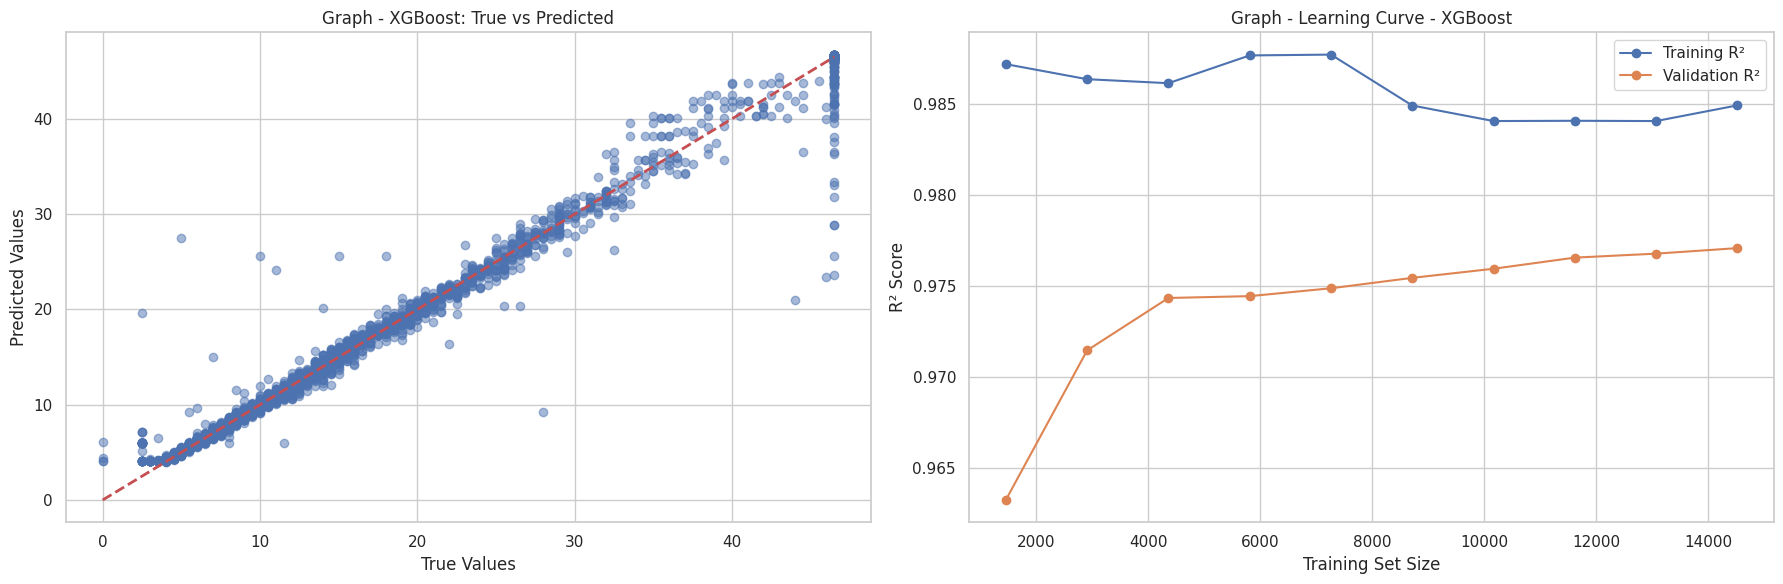

In [24]:
#----------------------------------------
# PT: Avaliação e seleção do melhor modelo:
#     - Calcula métricas no treino e teste (R², RMSE, MAE)
#     - Mostra diferença de R² entre treino e teste (overfitting/underfitting)
#     - Seleciona o melhor modelo baseado em R² no conjunto de teste
#     - Plota:
#         1. Verdadeiros vs Preditos
#         2. Curva de aprendizado (training vs validation R²)
#
# EN: Model evaluation and best model selection:
#     - Computes metrics on train and test (R², RMSE, MAE)
#     - Shows R² difference between train and test (overfitting/underfitting)
#     - Selects best model based on test R²
#     - Plots:
#         1. True vs Predicted
#         2. Learning Curve (training vs validation R²)
#----------------------------------------

best_score = -np.inf
best_model_name = None

for name, model in best_models.items():
    y_train_pred = model.predict(X_train_scaled)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    print(f">> {name} - Training metrics:")
    print(f"   R²:   {r2_train:.4f}")
    print(f"   RMSE: {rmse_train:.4f}")
    print(f"   MAE:  {mae_train:.4f}")

    y_test_pred = model.predict(X_test_scaled)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print(f">> {name} - Test metrics:")
    print(f"   R²:   {r2_test:.4f}")
    print(f"   RMSE: {rmse_test:.4f}")
    print(f"   MAE:  {r2_test:.4f}")

    print(f"[!] R² difference (test - train): {(r2_test - r2_train):.4f}\n")

    if r2_test > best_score:
        best_score = r2_test
        best_model_name = name

print(f">> Best model: {best_model_name} with R² = {best_score:.4f}\n")

plt.figure(figsize=(8,5))
y_best_pred = best_models[best_model_name].predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(18,6))

# 1. Scatter: True vs Predicted
axes[0].scatter(y_test, y_best_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2)
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title(f'Graph - {best_model_name}: True vs Predicted')
axes[0].grid(True)

# 2. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_models[best_model_name],
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

axes[1].plot(train_sizes, train_mean, 'o-', label="Training R²")
axes[1].plot(train_sizes, val_mean, 'o-', label="Validation R²")
axes[1].set_xlabel("Training Set Size")
axes[1].set_ylabel("R² Score")
axes[1].set_title(f"Graph - Learning Curve - {best_model_name}")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### **1. Comparação entre Modelos** / Detailed Model Analysis

**[ 🇧🇷 PT | 🇺🇸 EN ]**

#### 1. Análise Detalhada do Modelo

- **Regressão Linear**:  Desempenho mais baixo (R² ≈ 0,94), mas consistente entre treino e teste. Modelo simples, mas limitado para capturar relações não lineares.
- **Decision Tree**:  Boa performance (R² ≈ 0,97), porém com menor estabilidade que ensembles.
- **Random Forest**:  Forte ajuste no treino (R² ≈ 0,99), mas com queda no teste (≈0,977), sugerindo leve sobreajuste.
- **HistGradientBoostingRegressor (HistGBR)**:  Muito equilibrado, R² ≈ 0,977 no teste, com erros baixos e estabilidade entre treino e teste.
- **XGBoost**:  Melhor desempenho global, com R² = 0,9796 no teste, RMSE ≈ 1,34 e MAE ≈ 0,98. A diferença treino–teste foi pequena (-0,0045), mostrando excelente generalização.

>**Conclusão**: O **XGBoost** é o modelo mais indicado, pois entrega **alta precisão, robustez e ótima capacidade de generalização**.

#### 2. Capacidade de Explicação (R² ≈ 98%)

- O **XGBoost** explica aproximadamente **98% da variabilidade** da variável alvo (fare_amount).
- A diferença entre treino (0,9841) e teste (0,9796) foi de apenas **0,45%**, confirmando que o modelo não sofre de sobreajuste.

>**Interpretação de negócios**: o modelo captura praticamente todos os fatores que afetam a tarifa, produzindo previsões confiáveis.

#### 3. Erros Médios (MAE e RMSE)

- **MAE ≈ 0,98**: erro médio absoluto em torno de **1 unidade monetária**, baixo para a escala do problema.
- **RMSE ≈ 1,34**: mesmo penalizando mais erros grandes, o desvio médio segue baixo.

>Exemplo prático: para corridas de `$ 15–20`, o erro médio do modelo é de cerca de `$ 1`, adequado para uso real.

#### 4. Consistência e Aprendizado

A curva de aprendizado do XGBoost mostra que:
- O **R² de treino** inicia próximo de 0,988 e estabiliza em torno de 0,984.
- O **R² de validação** cresce continuamente até estabilizar perto de 0,978.

>Esse comportamento indica um modelo **regularizado, com baixo viés e baixa variância**. Não há indícios de overfitting.

#### 5. Conclusão Executiva

O XGBoost foi escolhido como melhor modelo, pois:
- Explica quase 98% da variabilidade da tarifa.
- Mantém erros médios baixos (≈1 unidade).
- Apresenta consistência entre treino e teste.
- Mostra aprendizado estável pela curva de validação.

>**Em termos de negócio**: pode ser aplicado com confiança, oferecendo previsões precisas que reduzem incerteza e apoiam **decisões estratégicas**.

---

**[ 🇺🇸 EN ]**

#### 1. Model Comparison

- **Linear Regression**:  Lowest performance (R² ≈ 0.94), but consistent across train and test. Too simple for nonlinear data.
- **Decision Tree**:  Solid performance (R² ≈ 0.97), but weaker generalization than ensembles.
- **Random Forest**:  Strong fit on training (R² ≈ 0.99), but drops on test (≈0.977), showing slight overfitting.
- **HistGradientBoostingRegressor (HistGBR)**:  Very balanced, R² ≈ 0.977 on test, with low errors and good stability.
- **XGBoost**:  Best overall model, with **R² = 0.9796** on test, RMSE ≈ 1.34, MAE ≈ 0.98, and a **small train–test gap (-0.0045)**.

>**Conclusion**: **XGBoost** is the most suitable model, combining **accuracy, robustness, and strong generalization**.

#### 2. Explanatory Power (R² ≈ 98%)

- XGBoost explains about **98% of the variance** in fare_amount.
- The train (0.9841) vs. test (0.9796) gap is only **0.45%**, proving no overfitting.

>**Business view**: the model captures almost all drivers of fare prices, ensuring reliable forecasts.

#### 3. Error Metrics (MAE and RMSE)

- **MAE ≈ 0.98**: average error of about **1 monetary unit**, negligible for this context.
- **RMSE ≈ 1.34**: even penalizing larger deviations, the error stays low.

>**Practical example**: for trips averaging `$ 15–20`, the model’s average error is just about `$ 1`, highly accurate for real-world applications.

#### 4. Consistency and Learning

The XGBoost learning curve shows:
- **Training R²** starts near 0.988 and stabilizes around 0.984.
- **Validation R²** steadily grows and levels at ~0.978.

>This is typical of a **well-regularized model, with low bias and low variance**. No signs of overfitting.

#### 5. Executive Conclusion

XGBoost was chosen as the best model because it:
- Explains ~98% of fare variability.
- Keeps errors very low (≈1 unit).
- Maintains strong train–test consistency.
- Shows stable and reliable learning behavior.

>**From a business perspective**: the model can be deployed confidently, providing precise predictions that reduce uncertainty and support **high-impact decisions**.


## **CONCLUSÕES** / CONCLUSIONS

**<a href="#NEW-YORK-CITY-YELLOW-TAXI---TRIP-FARE-PREDICTION">VOLTAR PARA O INÍCIO / BACK TO HOME</a>**

**[ 🇧🇷 PT | 🇺🇸 EN ]**

Este projeto demonstrou a aplicação de diferentes modelos de Machine Learning para previsão das tarifas de táxi em Nova Iorque, com destaque para o **XGBoost**, que apresentou o melhor desempenho geral (**R² ≈ 0,98, MAE ≈ 0,98 e RMSE ≈ 1,35**).

Os resultados mostram que o **modelo é capaz de explicar cerca de 98% da variabilidade** das tarifas, com erros médios muito baixos e consistentes entre treino e teste — evidenciando **boa generalização e ausência de overfitting relevante**. A análise dos erros (MAE e RMSE) reforça que as previsões são estáveis, pouco afetadas por outliers e próximas dos valores reais.

Do ponto de vista prático, o modelo tem grande potencial para aplicações reais, como suporte a políticas de precificação dinâmica, otimização de rotas e auxílio em tomadas de decisão estratégicas no setor de transporte urbano.

Como próximos passos, recomenda-se:

- Incorporar variáveis externas (clima, eventos, congestionamento).
- Aprimorar a seleção de hiperparâmetros com técnicas avançadas (Optuna, Bayesian Optimization).
- Explorar interpretabilidade de modelos (ex.: SHAP values) para compreender com maior clareza o impacto das variáveis na precificação.

>**Em síntese**: o projeto não apenas validou a viabilidade técnica da previsão de tarifas, mas também abriu espaço para aplicações práticas de alto impacto, com ganhos diretos em eficiência, precisão e valor estratégico.

---

**[ 🇺🇸 EN ]**

This project showcased the application of multiple Machine Learning models to predict taxi fares in New York City, with **XGBoost** standing out as the best performer (**R² ≈ 0.98, MAE ≈ 0.98, and RMSE ≈ 1.35**).

The results demonstrate that the **model explains around 98% of fare variability**, with very low and consistent errors across training and test sets — indicating **strong generalization and no significant overfitting**. Error analysis (MAE and RMSE) confirms that predictions are stable, minimally affected by outliers, and closely aligned with real values.

From a practical standpoint, the model has strong potential for real-world applications, such as supporting dynamic pricing policies, optimizing routes, and guiding strategic decision-making in urban transportation.

Recommended next steps include:

- Incorporating external variables (weather, events, traffic congestion).
- Refining hyperparameter tuning using advanced techniques (Optuna, Bayesian Optimization).
- Exploring model interpretability (e.g., SHAP values) to better understand variable impacts on fare pricing.

>**In summary**: the project not only validated the technical feasibility of fare prediction but also laid the groundwork for high-impact practical applications, driving improvements in efficiency, accuracy, and strategic value.

## **APÊNDICE - TESTE A/B (ANÁLISE EXTRA)** / APPENDIX - A/B TEST (EXTRA ANALYSIS)

**<a href="#NEW-YORK-CITY-YELLOW-TAXI---TRIP-FARE-PREDICTION">VOLTAR PARA O INÍCIO / BACK TO HOME</a>**

**[ 🇧🇷 PT | 🇺🇸 EN ]**

Como análise complementar, foi realizado um pequeno estudo comparando o valor médio das tarifas de corridas pagas em **cartão de crédito** e em **dinheiro**.

A média observada para pagamentos em cartão de crédito foi de **`$ 13,05` (desvio-padrão ≈ 9,81)**, enquanto para pagamentos em dinheiro a média foi de **`$11,91` (desvio-padrão ≈ 9,31)**. Essa diferença inicial sugere que clientes que pagam com cartão de crédito tendem a ter tarifas ligeiramente maiores.

Para verificar se essa diferença é **estatisticamente significativa** e não fruto do acaso, foi conduzido um teste de hipóteses (t-test) com as seguintes premissas:

- **Hipótese Nula (H₀)**: não há diferença entre as médias das tarifas pagas em cartão e em dinheiro.
- **Hipótese Alternativa (Hₐ)**: existe diferença entre as médias das tarifas pagas em cartão e em dinheiro.

O resultado do teste apresentou um **estatístico t = 8,45** e um **p-valor ≈ 0,00%**, muito inferior a níveis usuais de significância (1% ou 5%). Portanto, rejeitamos a hipótese nula, confirmando que há diferença real entre os grupos.

>**Conclusão extra**: a análise mostra que clientes que pagam em cartão de crédito tendem, em média, a pagar tarifas mais altas do que aqueles que pagam em dinheiro.

---

**[ 🇺🇸 EN ]**

As a complementary analysis, a study was conducted to compare the average fare amount for trips paid with **credit card** versus **cash**.

The observed mean for credit card payments was **`$ 13.05` (standard deviation ≈ 9.81)**, while the mean for cash payments was **`$ 11.91` (standard deviation ≈ 9.31)**. This initial difference suggests that customers paying by credit card tend to have slightly higher fares.

To verify whether this difference is **statistically significant** and not due to random variation, a hypothesis test (t-test) was performed with the following premises:

- **Null Hypothesis (H₀)**: there is no difference between the average fares of credit card and cash payments.
- **Alternative Hypothesis (Hₐ)**: there is a difference between the average fares of credit card and cash payments.

The test result showed a **t-statistic = 8.45** and a **p-value ≈ 0.00%**, far below common significance levels (1% or 5%). Therefore, we reject the null hypothesis, confirming that a real difference exists between the groups.

>**Extra conclusion**: the analysis indicates that customers who pay by credit card tend, on average, to pay higher fares than those who pay in cash.

In [25]:
#----------------------------------------
# PT: Análise de tarifas por tipo de pagamento:
#     - Separa dados em crédito (1) e dinheiro (2)
#     - Calcula média e desvio padrão do valor da corrida para cada grupo
#     - Compara estatísticas básicas entre formas de pagamento
#
# EN: Fare analysis by payment type:
#     - Splits data into credit (1) and cash (2)
#     - Computes mean and standard deviation of fare amount for each group
#     - Compares basic statistics between payment methods
#----------------------------------------

df_credit = df[df['payment_type']==1]
df_cash = df[df['payment_type']==2]

mean_credit = df_credit['fare_amount'].mean()
mean_cash = df_cash['fare_amount'].mean()

std_credit = df_credit['fare_amount'].std()
std_cash = df_cash['fare_amount'].std()

print(f'mean fare amount [credit]: {mean_credit:.2f} // mean fare amount [cash]: {mean_cash:.2f}')
print(f'std fare amount [credit]: {std_credit:.2f} // std fare amount [cash]: {std_cash:.2f}')

mean fare amount [credit]: 13.05 // mean fare amount [cash]: 11.91
std fare amount [credit]: 9.81 // std fare amount [cash]: 9.31


In [26]:
#----------------------------------------
# PT: Teste estatístico de comparação:
#     - Aplica t-test independente entre tarifas pagas em crédito e dinheiro
#     - Usa equal_var=False (variâncias não assumidas iguais)
#     - Retorna estatística do teste e valor-p (em %)
#
# EN: Statistical comparison test:
#     - Performs independent t-test between fares paid by credit and cash
#     - Uses equal_var=False (variances not assumed equal)
#     - Outputs test statistic and p-value (as %)
#----------------------------------------

statistic, pvalue = stats.ttest_ind(a=df_credit['fare_amount'],
                                    b=df_cash['fare_amount'],
                                    equal_var=False)
print(f'statistic: {statistic:.2f} // pvalue: {pvalue * 100:.2f}%')

statistic: 8.45 // pvalue: 0.00%
